In [45]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV

from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from yellowbrick.regressor import ResidualsPlot, PredictionError

import warnings
warnings.filterwarnings("ignore")

Bu projede, arabaların CO2 emisyonlarını tahmin etmek için hem Statsmodel hem de Scikit-learn'de SLR ve MLR modelleri oluşturacaksınız. 



SLR yaparken Engine Size(L) ve CO2 Emissions(g/km) columnlarını kullanacaksınız.



MLR Engine Size(L), Fuel Consumption Comb (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption City (L/100 km), CO2 Emissions(g/km) columnlarını kullanacaksınız.



Sanırım Target ve Featureleri kendiniz bulabilirsiniz.



Bunun haricinde Regularization derslerinde gördüğümüz (Scale, Cross Validation, Ridge-Lasso Regression Elastic Net, Grid Search) tüm parametrelerle skorlarımızı iyileştirelim

In [46]:
co2 = pd.read_csv("co2.csv")
df = co2.copy()
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [47]:
df.shape

(7385, 12)

veri seti, bir aracın CO2 emisyonlarının farklı özelliklere göre nasıl değişebileceğinin ayrıntılarını yakalıyor.
Bu, 7 yıllık bir süreye ait verileri içerir. Toplam 7385 satır ve 12 sütun bulunmaktadır.
Veri seti Kanada Hükümeti'nin resmi açık veri web sitesinden alınmıştır. Bu derlenmiş bir versiyondur.


Feature Information

Make: Vehicle brand

Model: Vehicle model

Vehicle Class: Vehicle class (e.g. small car, sports car, van, etc.)

Engine Size (L): Vehicle engine displacement (in liters)

Cylinders: Number of vehicle cylinders

Transmission: Vehicle gearbox type (manual or automatic)

Fuel Consumption City (L/100 km): Fuel consumption city (liters/100 km)

Fuel Consumption Hwy (L/100 km): Hwy fuel consumption (liters/100 km)

Fuel Consumption Comb (L/100 km): Average fuel consumption (liters/100 km)

Fuel Consumption Comb (mpg): Fuel economy (miles per gallon)


Şehir ve otoyol yakıt tüketimi değerleri 100 kilometre başına litre (L/100 km) cinsinden gösterilir; birleşik değer (%55 şehir, %45 hwy) L/100 km ve galon başına mil (mpg) cinsinden gösterilir.

CO2 Emissions (g/km): CO2 emissions per vehicle (grams/kilometer)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [49]:
# ilk iş sutun adlarını düzenlemek olacak
renamed_columns = {
    'Make' : "make",
    'Model' : "model",
    'Vehicle Class': 'vehicle_class',
    'Engine Size(L)': 'engine_size',
    'Cylinders': "cylinders",
    'Transmission' : "transmission",
    'Fuel Type': 'fuel_type',
    'Fuel Consumption City (L/100 km)': 'fuel_cons_city',
    'Fuel Consumption Hwy (L/100 km)': 'fuel_cons_hwy',
    'Fuel Consumption Comb (L/100 km)': 'fuel_cons_comb',
    'Fuel Consumption Comb (mpg)': 'mpgfuel_cons_comb',
    'CO2 Emissions(g/km)': 'co2'
}
df.rename(renamed_columns, axis='columns', inplace=True)

In [50]:
# missing value leri kontrol edelim
df.isnull().sum()

make                 0
model                0
vehicle_class        0
engine_size          0
cylinders            0
transmission         0
fuel_type            0
fuel_cons_city       0
fuel_cons_hwy        0
fuel_cons_comb       0
mpgfuel_cons_comb    0
co2                  0
dtype: int64

In [51]:
# verimizi özetleyelim
df.describe().T

,count,mean,std,min,25%,50%,75%,max
engine_size,7385.0,3.160068,1.354170,0.9,2.0,3.0,3.7,8.4
cylinders,7385.0,5.615030,1.828307,3.0,4.0,6.0,6.0,16.0
fuel_cons_city,7385.0,12.556534,3.500274,4.2,10.1,12.1,14.6,30.6
fuel_cons_hwy,7385.0,9.041706,2.224456,4.0,7.5,8.7,10.2,20.6
fuel_cons_comb,7385.0,10.975071,2.892506,4.1,8.9,10.6,12.6,26.1
mpgfuel_cons_comb,7385.0,27.481652,7.231879,11.0,22.0,27.0,32.0,69.0
co2,7385.0,250.584699,58.512679,96.0,208.0,246.0,288.0,522.0


# BURDA bitane fonksiyon oluşturup tablo yapacagım ve tablo şeklinde veri setimi inceleyecegim numeric ve kategoric veriler açısından

In [52]:
# data için tablo oluştur

def get_unique_values(df):
    
    output_data = []

    for col in df.columns:

        # Sütundaki benzersiz değerlerin sayısı 5'ten küçük veya ona eşitse
        if df.loc[:, col].nunique() <= 10:
            # Sütundaki benzersiz değerleri aldık
            unique_values = df.loc[:, col].unique()
            # Sütun adını, benzersiz değer sayısını, benzersiz değerleri ve veri türünü çıktı verilerine ekledik
            output_data.append([col, df.loc[:, col].nunique(), unique_values, df.loc[:, col].dtype])
        else:
            # Aksi takdirde, çıktı verilerine yalnızca sütun adını, benzersiz değer sayısını ve veri türünü ekledik
            output_data.append([col, df.loc[:, col].nunique(),"-", df.loc[:, col].dtype])

    output_df = pd.DataFrame(output_data, columns=['Column Name', 'Number of Unique Values', ' Unique Values ', 'Data Type'])

    return output_df

In [53]:
get_unique_values(df)

,Column Name,Number of Unique Values,Unique Values,Data Type
0,make,42,-,object
1,model,2053,-,object
2,vehicle_class,16,-,object
3,engine_size,51,-,float64
4,cylinders,8,"[4, 6, 12, 8, 10, 3, 5, 16]",int64
5,transmission,27,-,object
6,fuel_type,5,"[Z, D, X, E, N]",object
7,fuel_cons_city,211,-,float64
8,fuel_cons_hwy,143,-,float64
9,fuel_cons_comb,181,-,float64


Motor Boyutu(L), Silindirler, Şehir Yakıt Tüketimi (L/100 km), Yakıt Tüketimi Yolu (L/100 km), Yakıt Tüketimi otoyol (L/100 km), Yakıt Tüketimi otoyol (mpg) ve CO2 Emisyonları( g/km) sayısaldır ve doğası gereği süreklidir.
Marka, Model, Araç Sınıfı, Şanzıman ve Yakıt Türü sütunları doğası gereği kategoriktir.

Number of Unique Values	: benzersiz dege sayısı

Unique Values : benzersiz degerler


In [54]:
# Duplicated data

df_duplicated = df[df.duplicated() == True]
df_duplicated.shape

(1103, 12)

Veri setinde yinelenen satırlar var. Ancak doğrusal bir model kullanacağım için bu satırları silmeyi düşünmüyorum çünkü yinelenen satırlar benzer değerler içeriyor. Doğrusal regresyon, veri noktalarının genel eğilimini bulmaya çalışır ve yinelenen satırların benzer değerler içermesi, modelin tahminlerinde büyük bir değişikliğe yol açmaz.

# Categorical Features

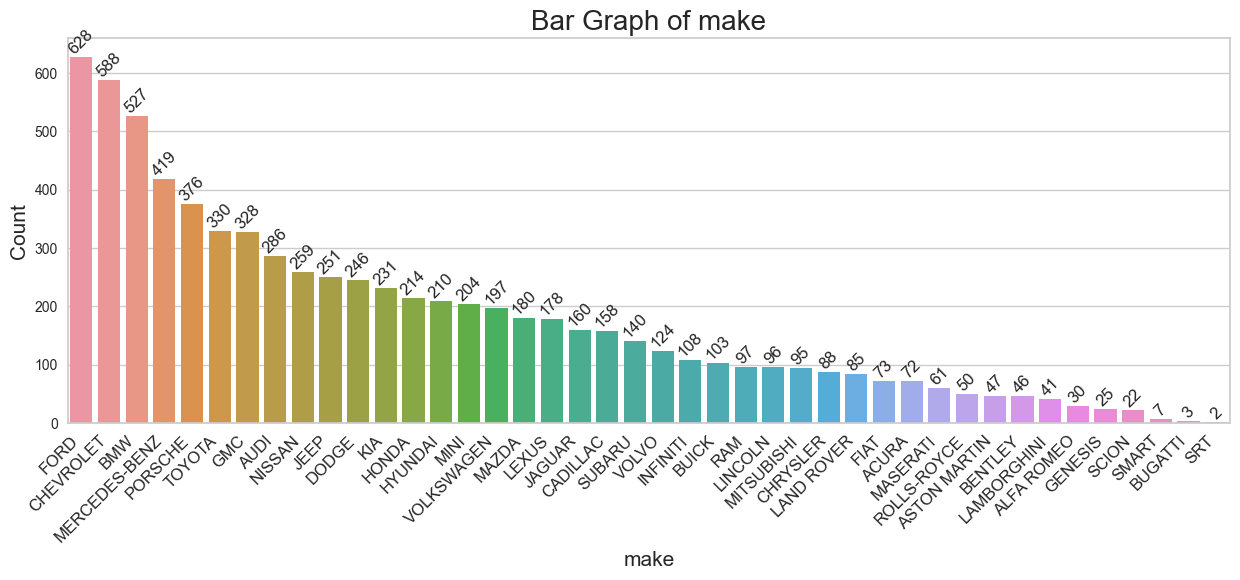

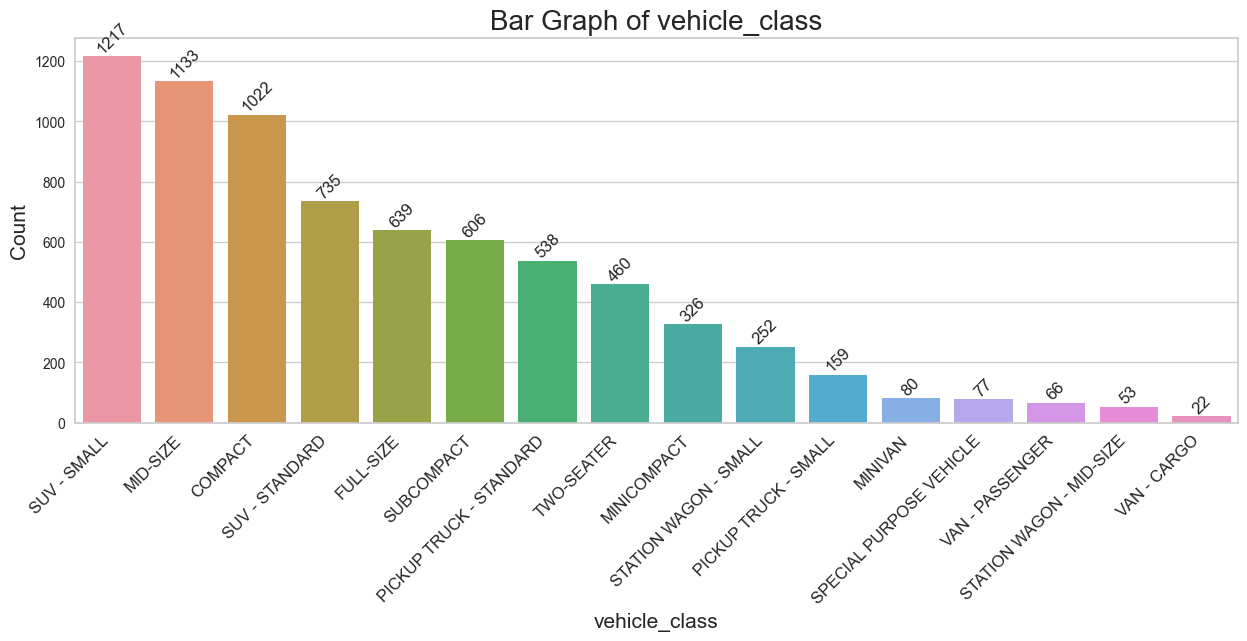

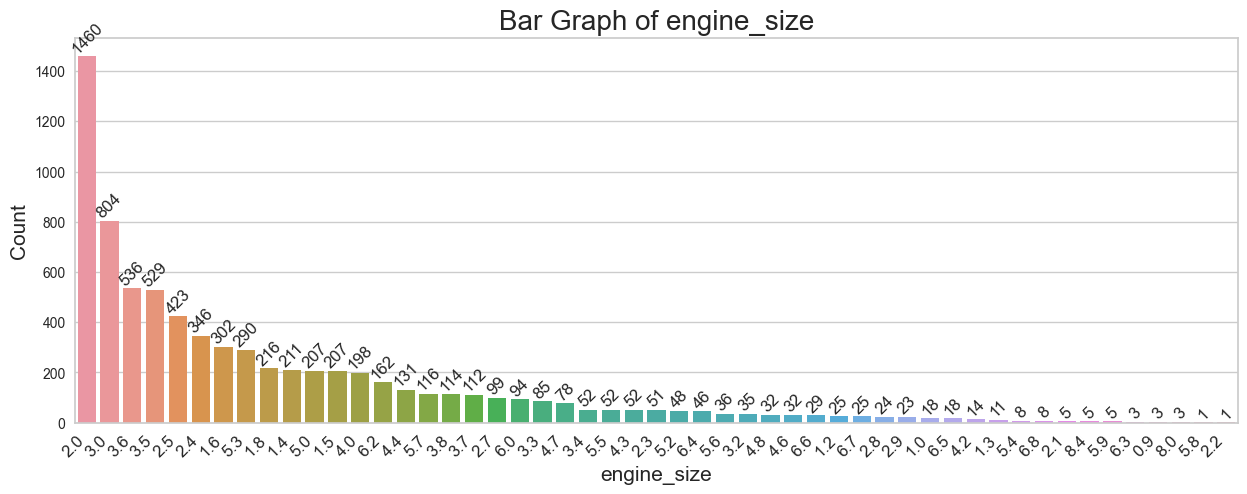

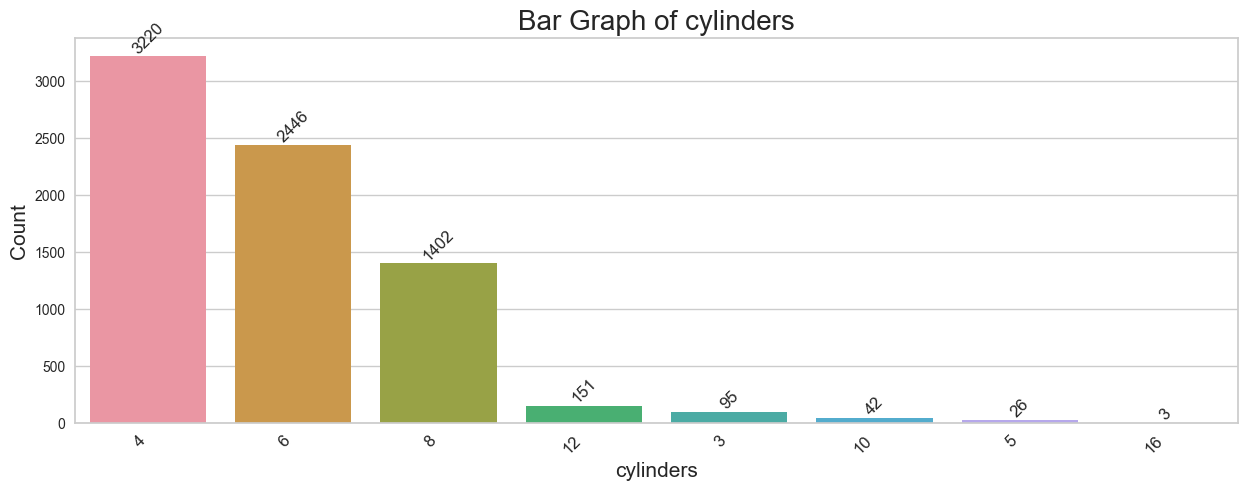

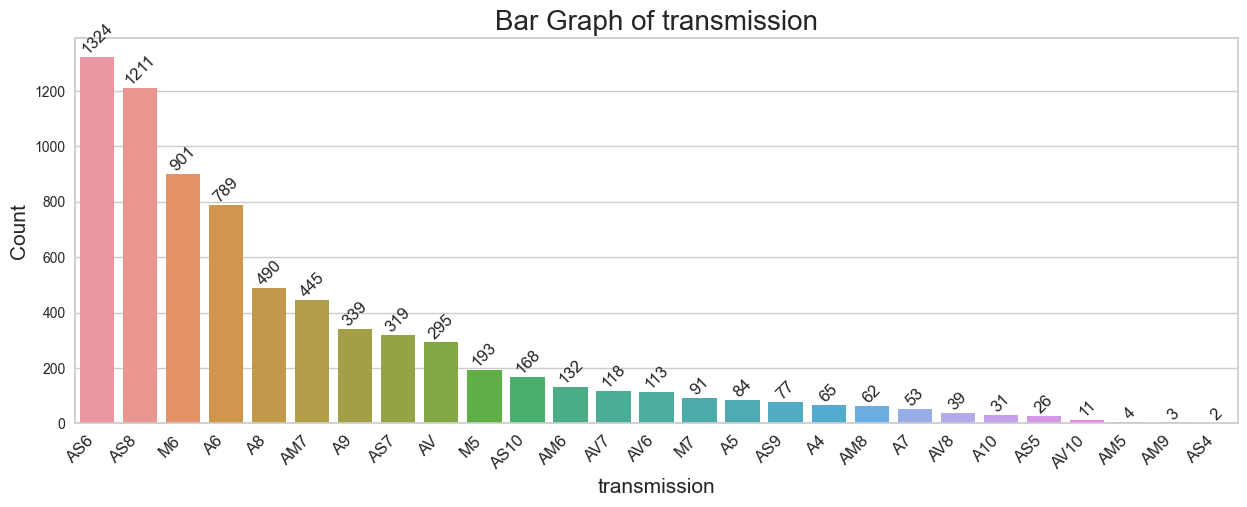

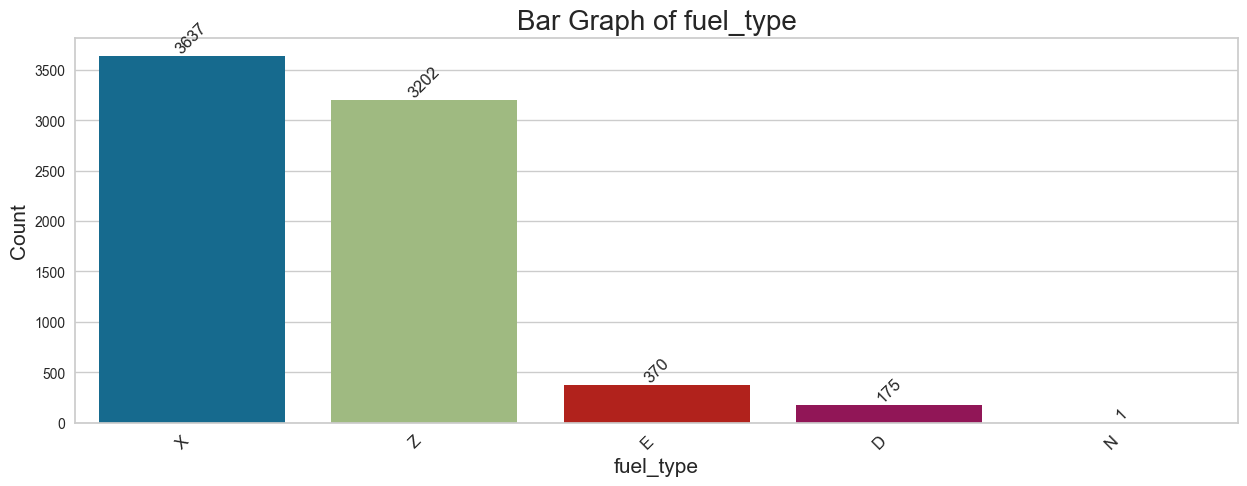

In [55]:
def plot_bar_graphs(df, columns):
    for column in columns:
        plt.figure(figsize=(15, 5))
        ax = sns.countplot(x=column, data=df, order=df[column].value_counts().index)
        ax.bar_label(ax.containers[0],rotation=45)
        plt.xlabel(column, fontsize=15)
        plt.ylabel('Count', fontsize=15)
        plt.title(f'Bar Graph of {column}', fontsize=20)
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.show()
        
cat_features = ['make', 'vehicle_class', 'engine_size', 'cylinders', 'transmission', 'fuel_type']

plot_bar_graphs(df, cat_features)


Yukarıdaki grafiklerden de görülebileceği gibi:

Veri setinde dizel, etanol ve doğalgaz yakıtı tüketen araç sayısı oldukça azdır.
AS6, AS8, M6, A6, A9'un şanzıman seçeneği olarak yaygın kullanımı
Silindir seçeneği olarak yaygın olarak 4, 6, 8 kullanılır
2,0 ve 3,0 yoğunluk seçenekleriyle Motor Boyutu (L)
Veri kümesine genellikle daha küçük boyutlu araçlar hakimdir

In [ ]:
# Kategorik niteliklerimiz ile hedef değişken arasındaki ilişkiye bakalım

def plot_bar_with_co2(df, columns):
    for column in columns:
        plt.figure(figsize=(15, 5))
        grouped_data = df.groupby(column)['co2'].mean().round(1).reset_index()
        grouped_data_sorted = grouped_data.sort_values(by='co2', ascending=False)
        ax = sns.barplot(x=column, y='co2', data=grouped_data_sorted, order=grouped_data_sorted[column])
        ax.bar_label(ax.containers[0],rotation=90)
        plt.xlabel(column, fontsize=18)
        plt.ylabel('Mean Co2 Emission', fontsize=15)
        plt.title(f'Mean Co2 Emission by {column}', fontsize=20)
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.show()
        
plot_bar_with_co2(df, cat_features)

Yukarıdaki grafiklerden de görülebileceği gibi:

Bugatti en yüksek ortalama Co2 emisyonuna sahip
Büyük hacimli araçların CO2 emisyon ortalamaları yüksektir
Yüksek hacimli ve silindirli motorların C02 emisyon ortalamaları da yüksektir
Etanol en yüksek CO2 ortalamasına sahip yakıttır

# Numerical Features

def numerical_dist(df, columns):
    for column in columns:
        plt.figure(figsize=(15, 5))
        sns.distplot(x=df[column])
        plt.xlabel(column, fontsize=15)
        plt.ylabel('Count', fontsize=15)
        plt.title(f'Distribution of {column}', fontsize=20)
        plt.show()
        
num_features = ['fuel_cons_city', 'fuel_cons_hwy','fuel_cons_comb', 'mpgfuel_cons_comb', 'co2']

numerical_dist(df, num_features)

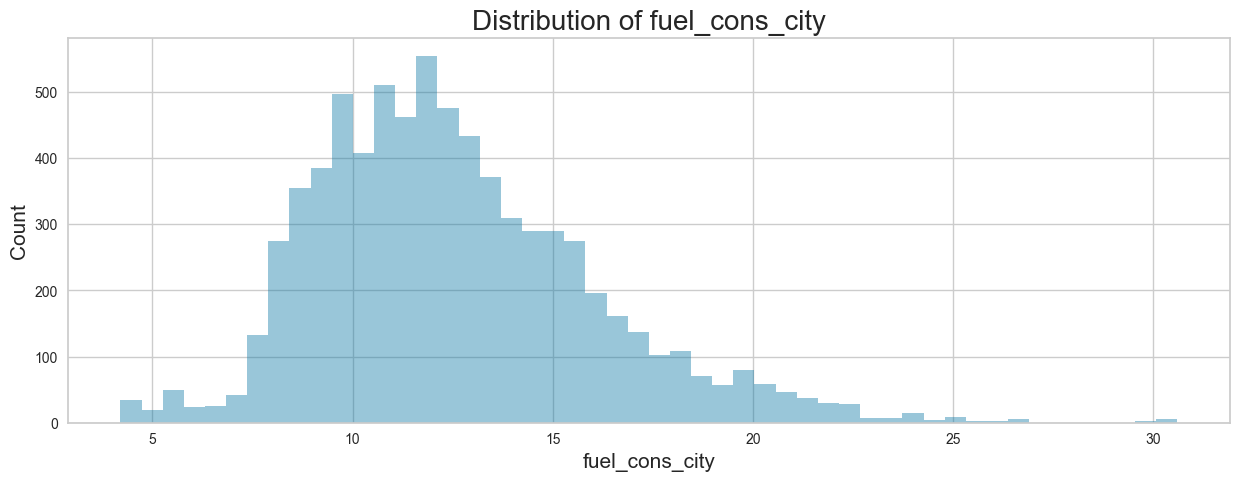

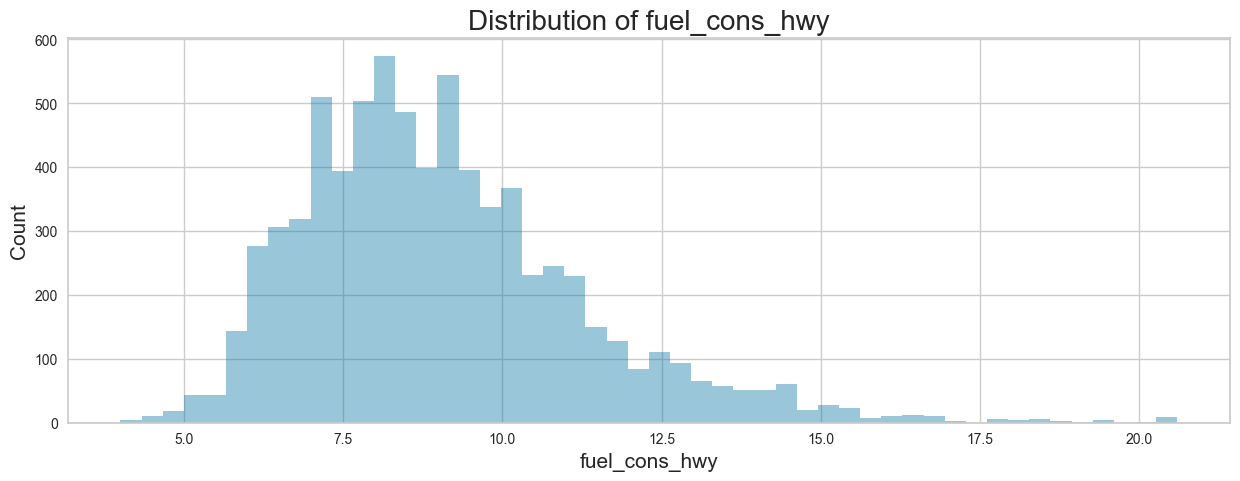

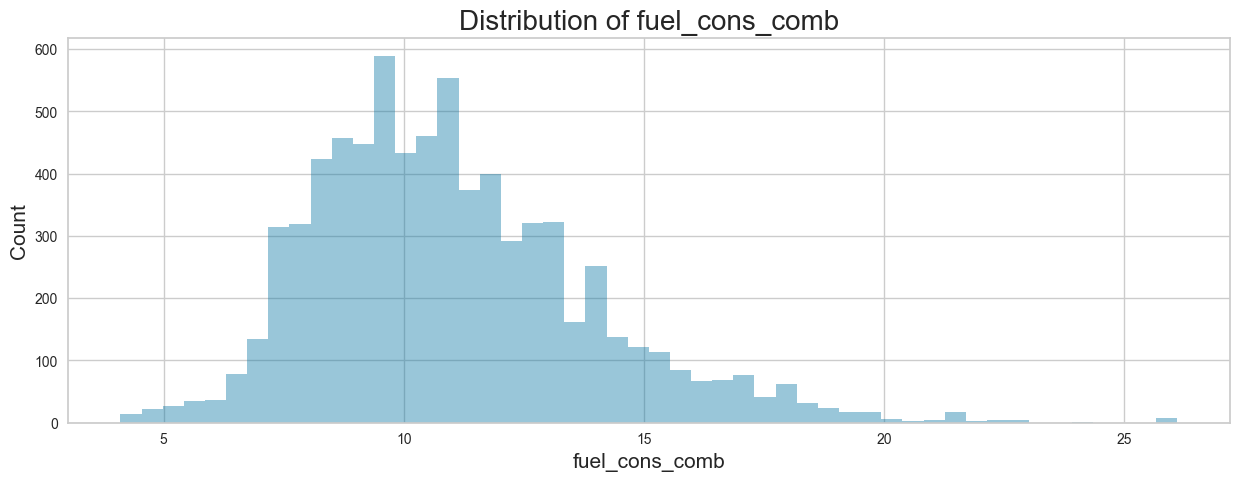

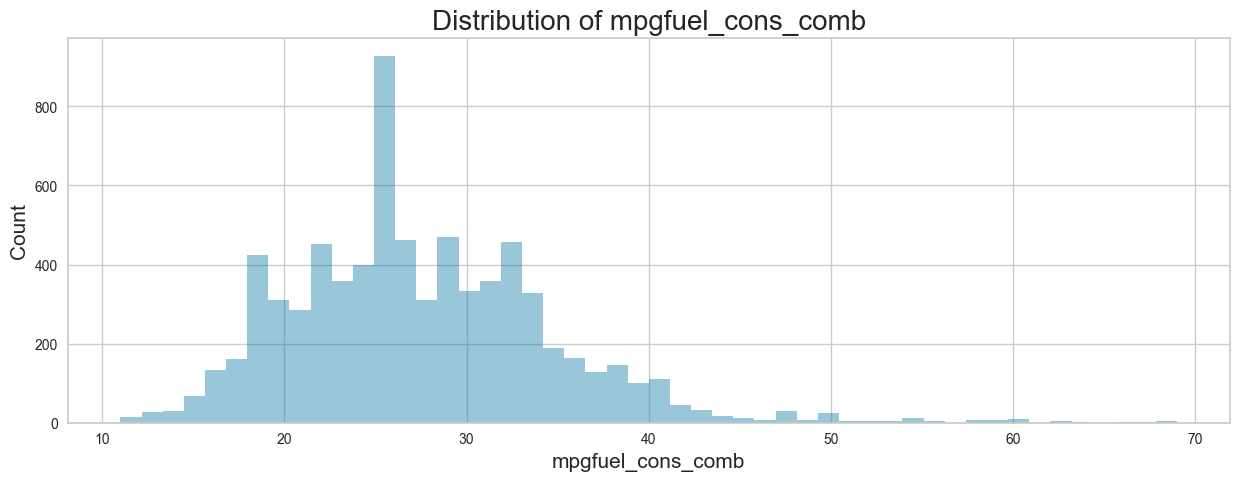

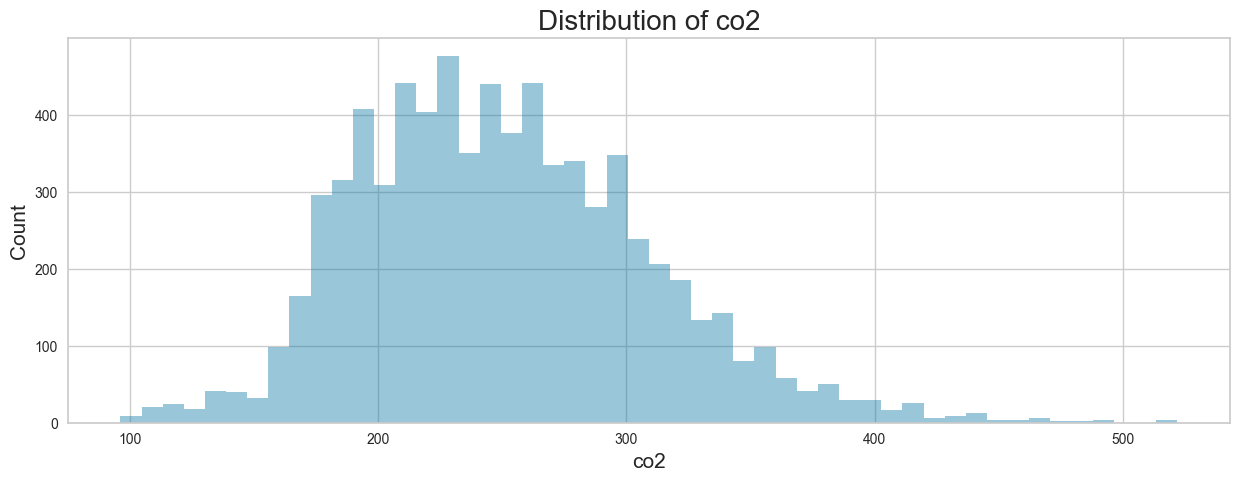

In [56]:
def numerical_dist(df, columns):
    for column in columns:
        plt.figure(figsize=(15, 5))
        sns.distplot(x=df[column],kde=False)
        plt.xlabel(column, fontsize=15)
        plt.ylabel('Count', fontsize=15)
        plt.title(f'Distribution of {column}', fontsize=20)
        plt.show()
        
num_features = ['fuel_cons_city', 'fuel_cons_hwy','fuel_cons_comb', 'mpgfuel_cons_comb', 'co2']

numerical_dist(df, num_features)

burda distplot ile sürekli hata aldıgım için histplot yaptım hatanın kaynagını buldum ama çözemedim

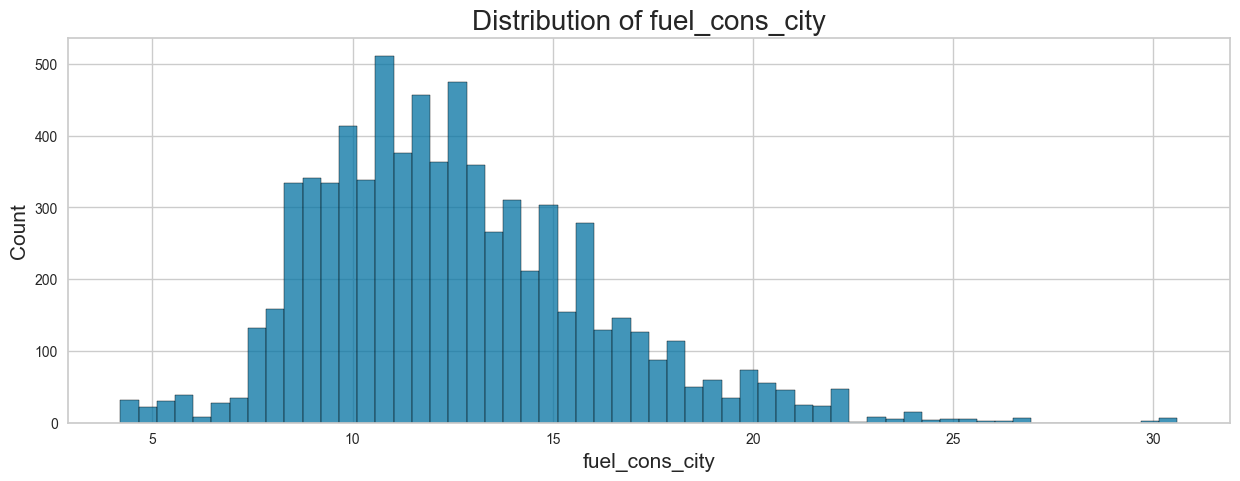

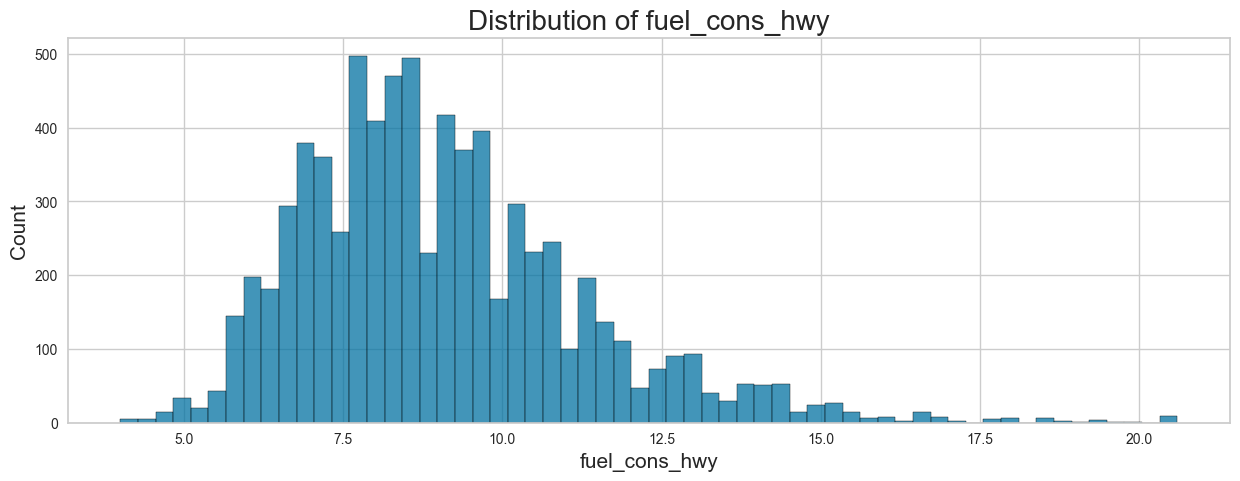

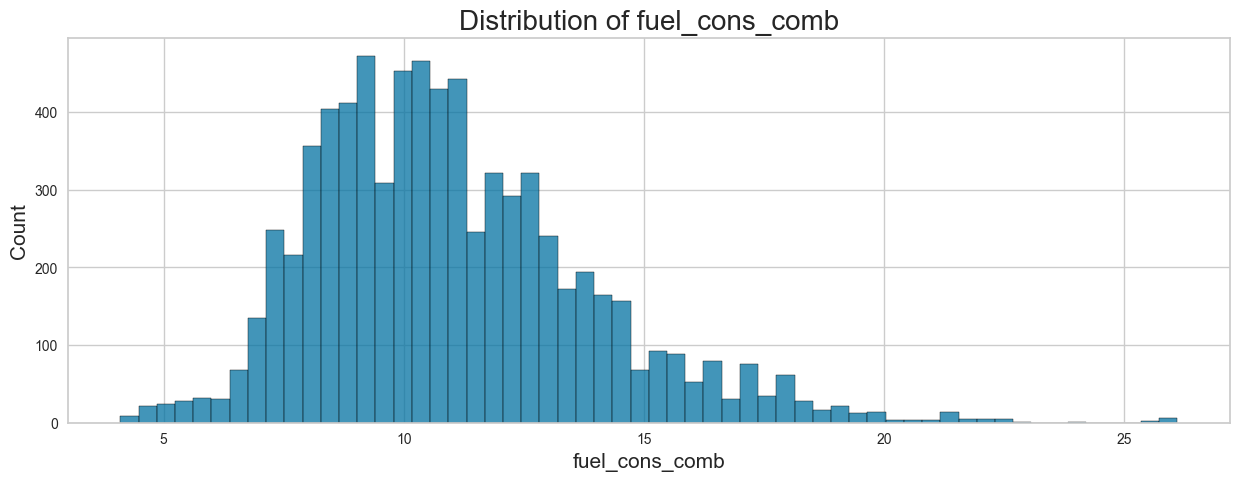

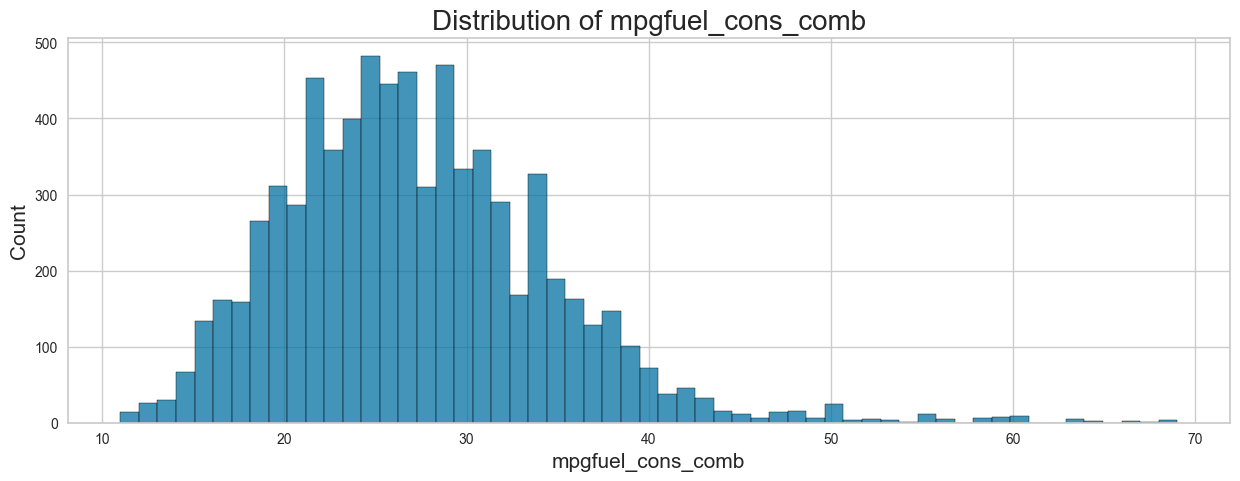

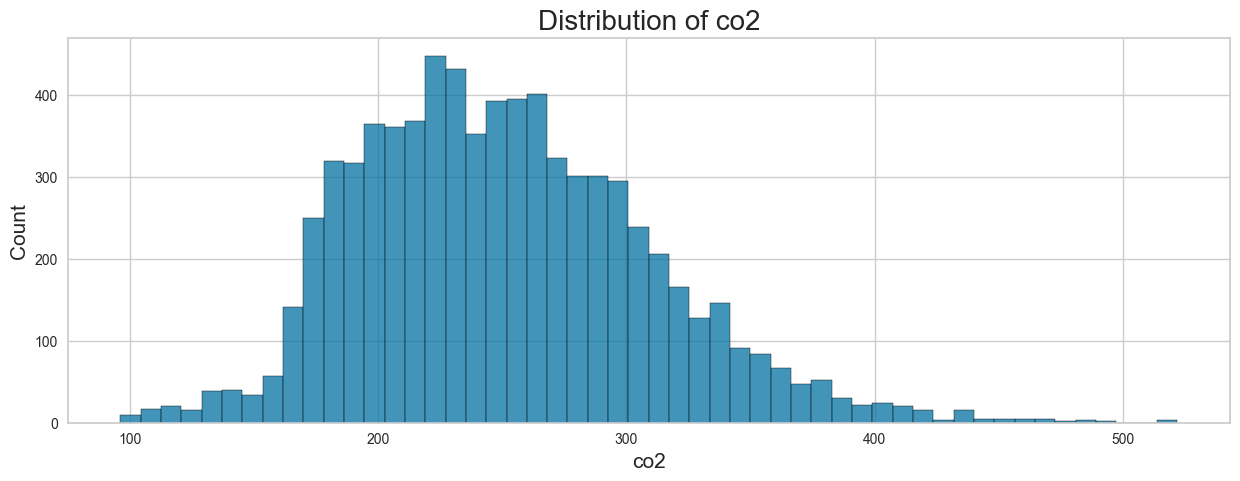

In [57]:
def numerical_dist(df, columns):
    for column in columns:
        plt.figure(figsize=(15, 5))
        sns.histplot(x=df[column])
        plt.xlabel(column, fontsize=15)
        plt.ylabel('Count', fontsize=15)
        plt.title(f'Distribution of {column}', fontsize=20)
        plt.show()
        
num_features = ['fuel_cons_city', 'fuel_cons_hwy','fuel_cons_comb', 'mpgfuel_cons_comb', 'co2']

numerical_dist(df, num_features)

In [ ]:
# Consumption of Highway and City

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="fuel_cons_hwy", kde=False, label = "Fuel Consumption in Highway",color = "orange")
sns.histplot(data=df, x="fuel_cons_city", kde=False, label = "Fuel Consumption in City")
plt.xlabel('Consumption (L/100 km)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Histogram of Highway and City', fontsize=16)
plt.legend()
plt.show()

Grafikten de görülebileceği gibi karayollarında yakıt tüketimi daha fazladır

# Outliers Check

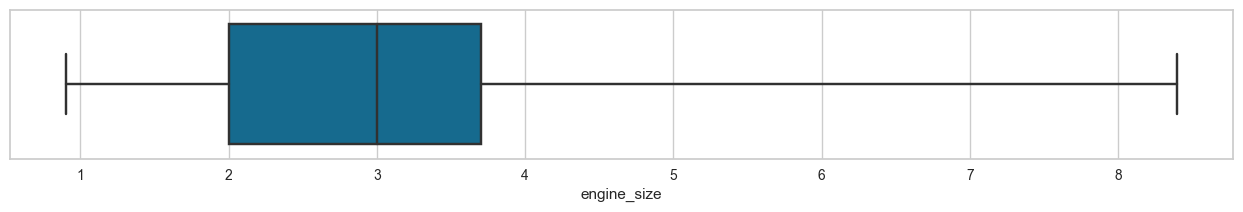

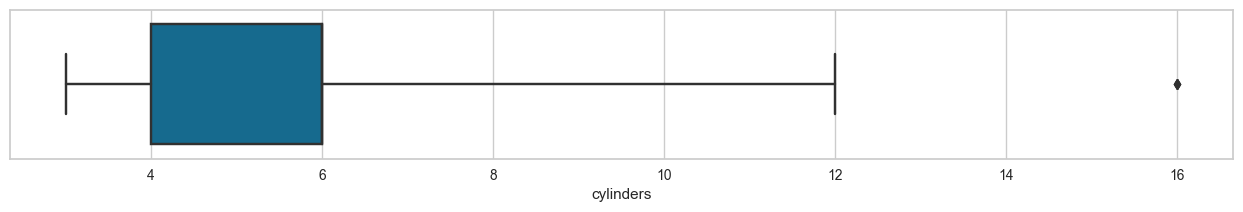

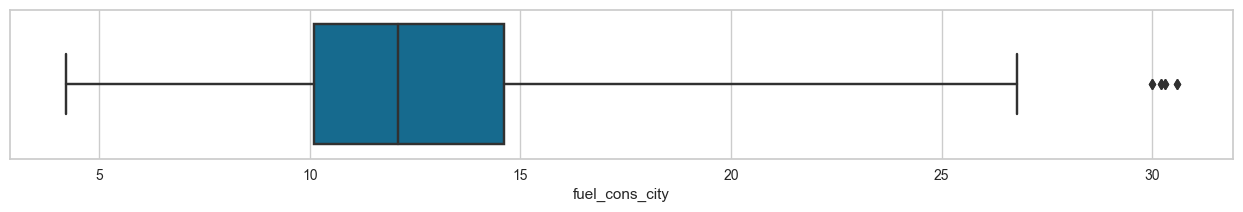

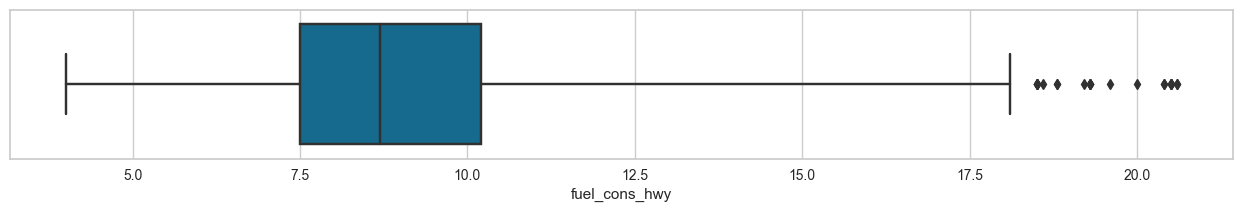

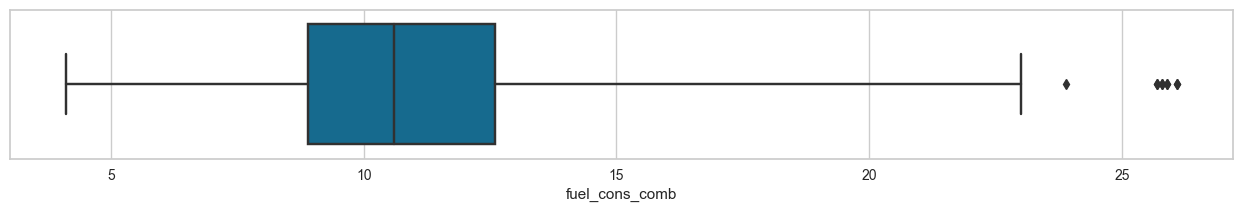

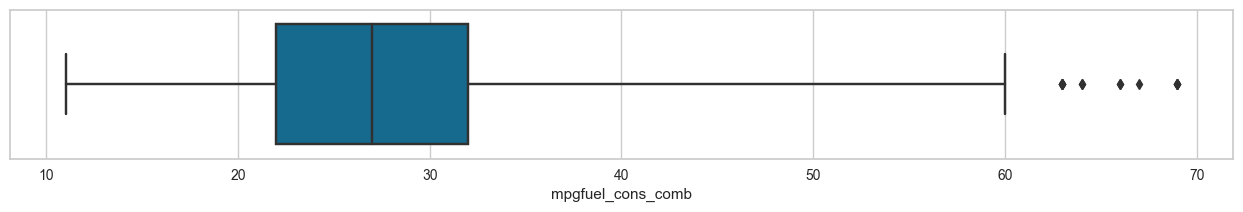

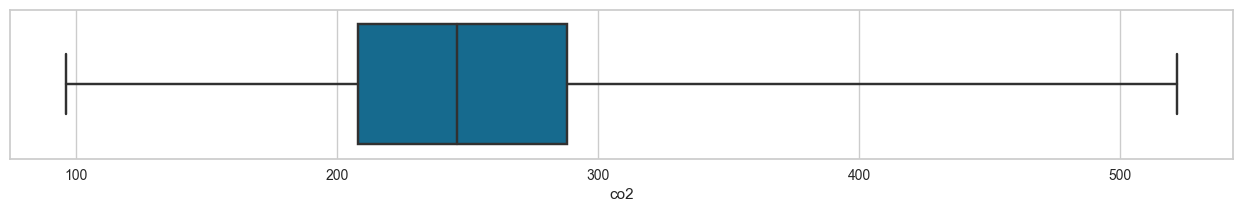

In [58]:
index=0
for feature in df.select_dtypes('number').columns:
    index+=1
    plt.figure(figsize=(25,25))
    plt.subplot((len(df.columns)),2,index)
    sns.boxplot(x=feature,data=df,whis=3) 
        
    plt.tight_layout()
    
    plt.show()

Şu anda aykırı değerlere müdahale etmiyoruz ancak modelin tahmin performansına göre daha sonra aksiyon alabiliriz.

# Correlation

In [59]:
# renkli korealosyon tablosu

def color_red(val):
    
    if val > 0.90 and val < 0.99:
        color = 'red'
    elif val < -0.90 and val > -1.00:
        color = "red"
    elif val == 1:
        color = "blue"
    elif val >= -0.30 and val <= 0:
        color = "green"
    elif val <= 0.30 and val > 0:
        color = "green"
    else:
        color = 'black'
    return f'color: {color}'

df.corr().style.applymap(color_red)

,engine_size,cylinders,fuel_cons_city,fuel_cons_hwy,fuel_cons_comb,mpgfuel_cons_comb,co2
engine_size,1.000000,0.927653,0.831379,0.761526,0.817060,-0.757854,0.851145
cylinders,0.927653,1.000000,0.800702,0.715252,0.780534,-0.719321,0.832644
fuel_cons_city,0.831379,0.800702,1.000000,0.948180,0.993810,-0.927059,0.919592
fuel_cons_hwy,0.761526,0.715252,0.948180,1.000000,0.977299,-0.890638,0.883536
fuel_cons_comb,0.817060,0.780534,0.993810,0.977299,1.000000,-0.925576,0.918052
mpgfuel_cons_comb,-0.757854,-0.719321,-0.927059,-0.890638,-0.925576,1.000000,-0.907426
co2,0.851145,0.832644,0.919592,0.883536,0.918052,-0.907426,1.000000


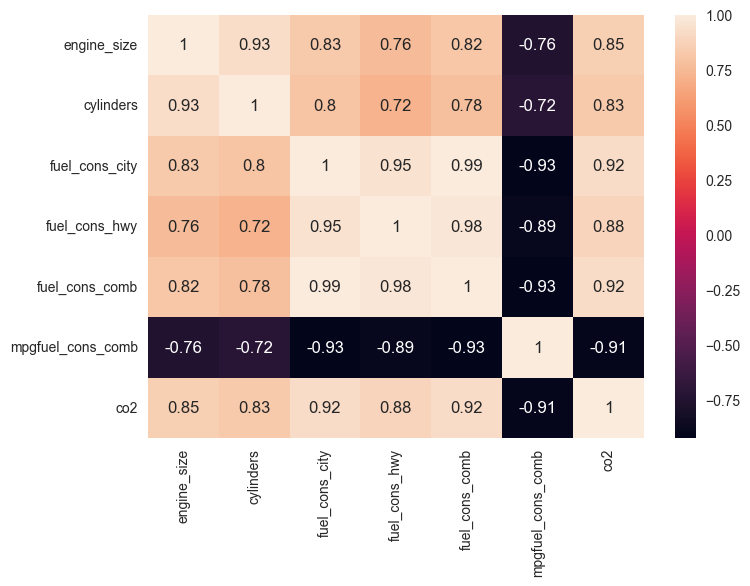

In [60]:
sns.heatmap(df.corr(), annot=True);

Yakıt Tüketimi (mpg) tüm özelliklerle negatif ilişkilidir.
Diğer tüm özellikler birbiriyle pozitif korelasyona sahiptir

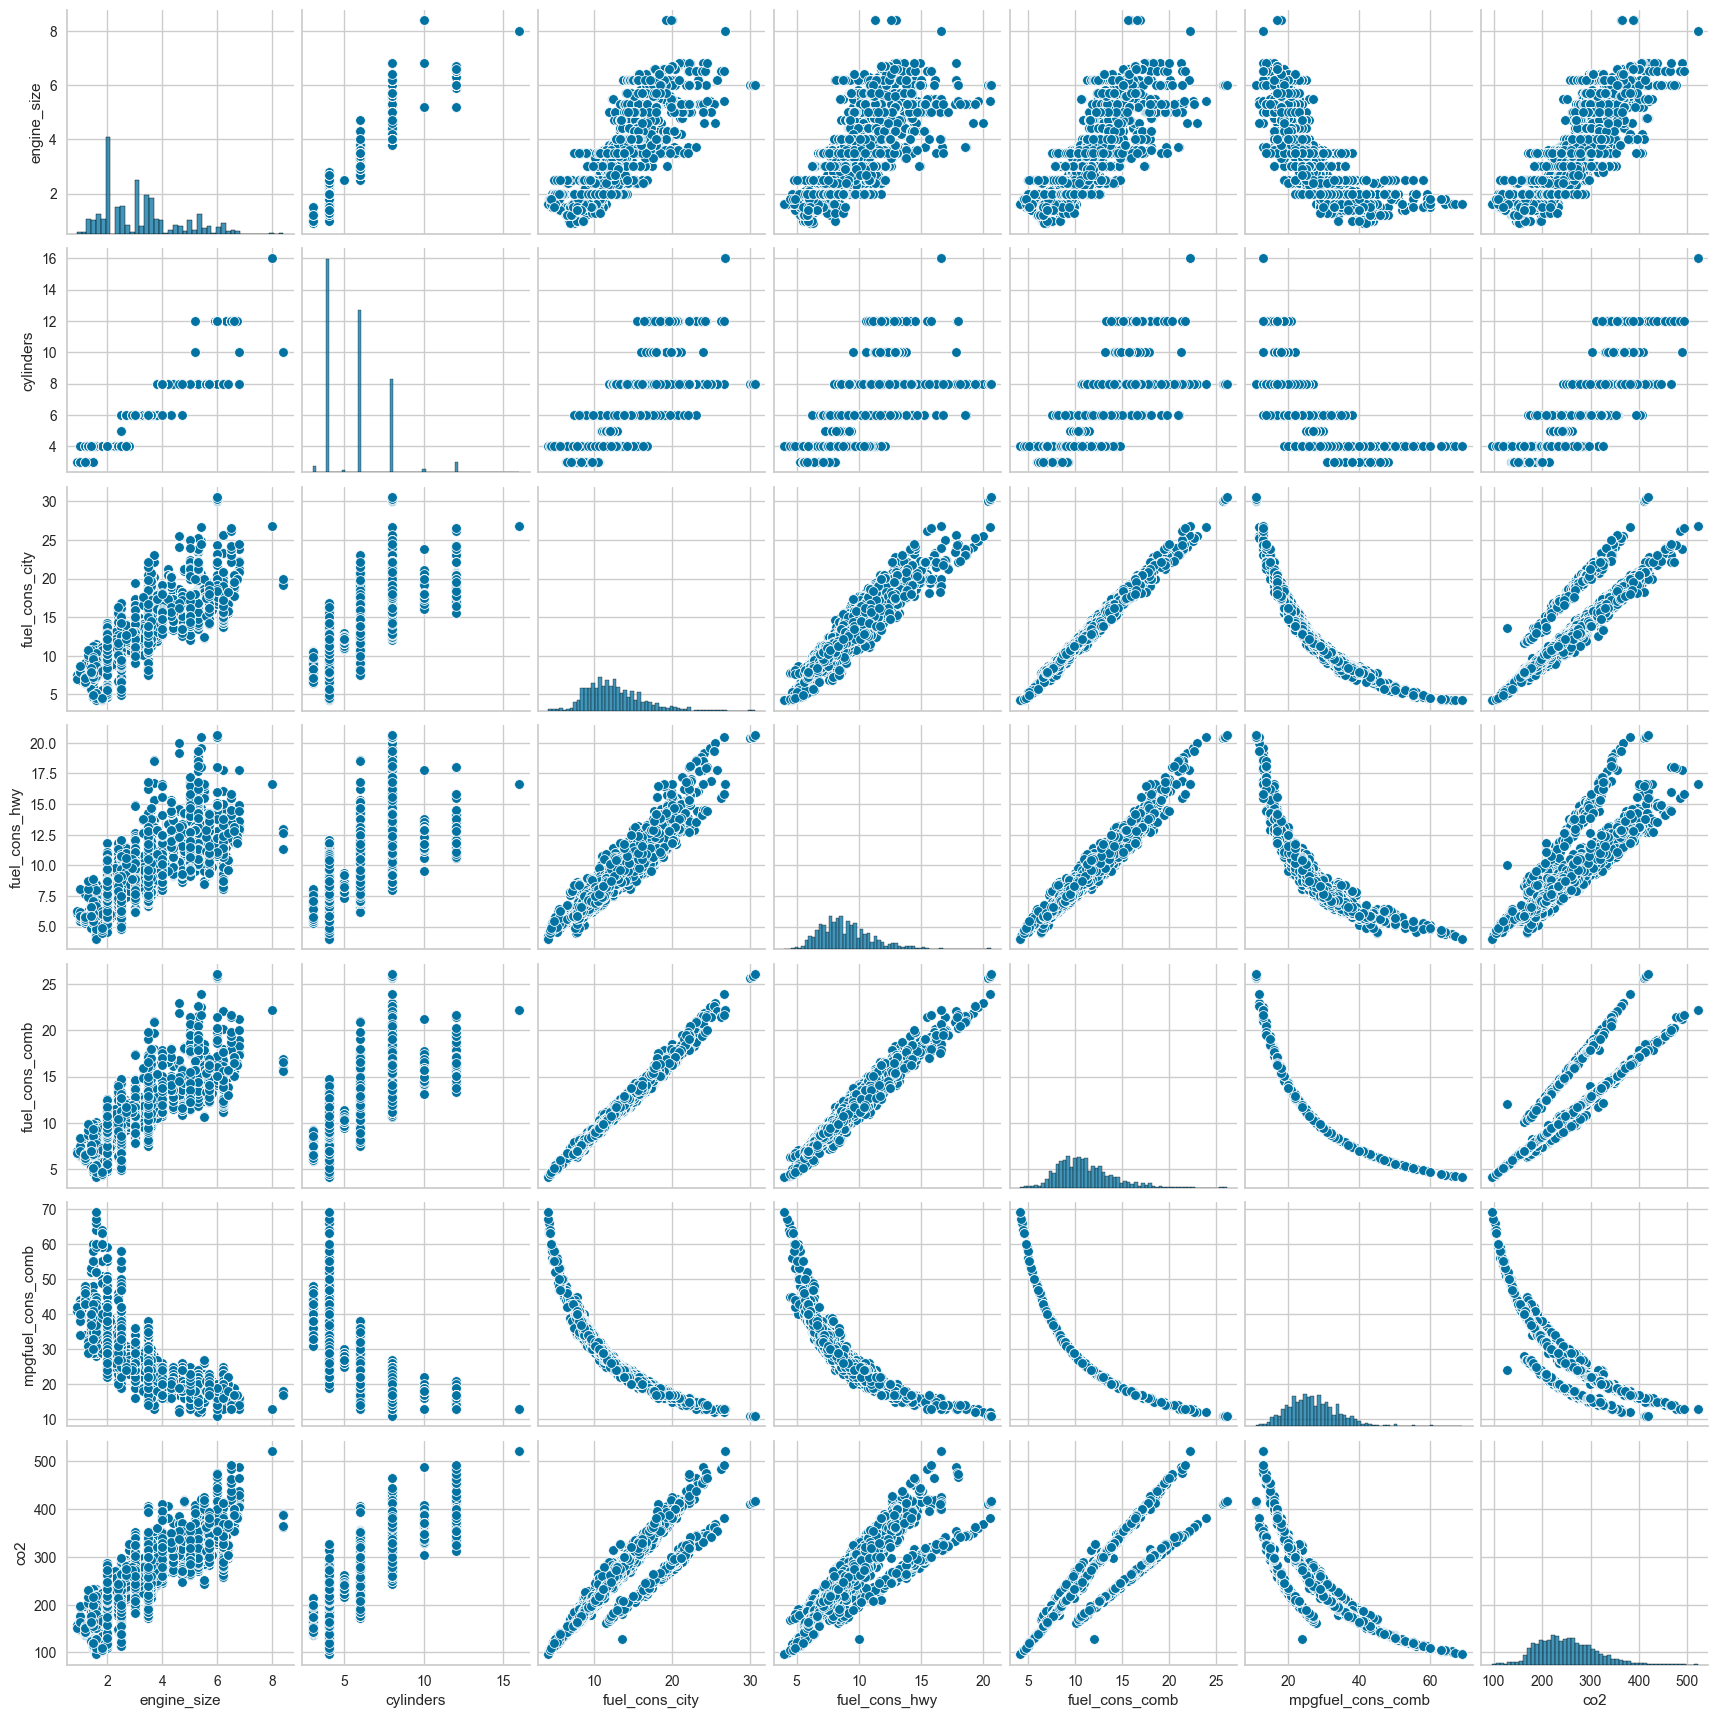

In [61]:
sns.pairplot(df);

Hedef değişkenimizin diğer özelliklerle dağılımına baktığımızda aralarındaki doğrusal ilişki doğrusal modelimizin iyi performans göstereceğini göstermektedir.
Aslında aşağıdaki tablodan, herhangi bir kategorik sütun kullanmadan, yalnızca sayısal sütunlarla yüksek tahminler elde etmeyi umduğum açıkça görülüyor.
Modelimiz için yakıt tüketiminde şehir ve otoyolun birleşimi olan Fuel_cons_comb sütununu seçebiliriz. Diğer ikisi çoklu bağlantıya neden olacaktır. Böylece aşağıdaki sayısal sütunları seçebiliriz.
-engine_size

-cylinders

-fuel_cons_comb

-mpgfuel_cons_comb

# MODELLİNG

Simple Lineer Regression

Train-Test Split

In [ ]:
X = df[["engine_size"]]
y = df["co2"]

In [ ]:
from sklearn.model_selection import train_test_split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [63]:
for i in (X_train, X_test, y_train, y_test):
    print(i.shape)

(5908, 1)
(1477, 1)
(5908,)
(1477,)


##Manuel Lineer Regresyon

In [64]:
np.polyfit(X_train.engine_size, y_train, deg = 1)

array([ 36.61217814, 135.05657623])

In [65]:
b1, b0 = np.polyfit(X_train.engine_size, y_train, deg = 1)

In [66]:
print("b1        :", b1)
print("b0        :", b0)

b1        : 36.61217814221727
b0        : 135.05657623459277


In [67]:
y_pred_test = b1 * X_test + b0
y_pred_test

,engine_size
7261,244.893111
4489,296.150160
1539,362.052081
3532,329.101120
6418,281.505289
...,...
7185,208.280933
1740,208.280933
4609,186.313626
1844,263.199200


In [68]:
y_pred_train = b1 * X_train + b0
y_pred_train

,engine_size
6590,244.893111
6274,281.505289
2251,244.893111
3149,259.537982
4362,208.280933
...,...
5191,208.280933
5226,263.199200
5390,263.199200
860,226.587022


In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [70]:
def eval_metric(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    
    print("--------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")
    
print("Model testing performance: ")   
eval_metric(y_test, y_pred_test)

Model testing performance: 
--------------------------
R2_score 	: 0.7238115822302347
MAE 		: 22.927177134341978
MSE 		: 949.9852533375347
RMSE 		: 30.821830791462318


In [71]:
print("Model training performance: ")
eval_metric(y_train, y_pred_train)

Model training performance: 
--------------------------
R2_score 	: 0.7245276280573065
MAE 		: 23.374986568616393
MSE 		: 941.7163581594913
RMSE 		: 30.687397383282462


LinearRegression (scikit learn)

In [72]:
from sklearn.linear_model import LinearRegression

In [73]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [74]:
lin_reg.coef_  # b1 skoruydu bu

array([36.61217814])

In [75]:
lin_reg.intercept_ # b0 intercept degeri

135.05657623459336

In [76]:
y_pred_test = lin_reg.predict(X_test)
y_pred_test

array([244.89311066, 296.15016006, 362.05208072, ..., 186.31362563,
       263.19919973, 208.28093252])

In [77]:
y_pred_train = lin_reg.predict(X_train)
y_pred_train

array([244.89311066, 281.5052888 , 244.89311066, ..., 263.19919973,
       226.58702159, 281.5052888 ])

In [78]:
print("Model testing performance: ")
eval_metric(y_test, y_pred_test)

Model testing performance: 
--------------------------
R2_score 	: 0.7238115822302345
MAE 		: 22.927177134342056
MSE 		: 949.9852533375358
RMSE 		: 30.821830791462336


In [79]:
print("Model training performance: ")
eval_metric(y_train, y_pred_train)

Model training performance: 
--------------------------
R2_score 	: 0.7245276280573065
MAE 		: 23.374986568616432
MSE 		: 941.7163581594913
RMSE 		: 30.687397383282462


MAE ve RMSE arasındaki fark outlier oldugunu gösterir

In [80]:
my_dict = {"Actual": y_test, "pred": y_pred_test, "residual": y_test - y_pred_test}
compare = pd.DataFrame(my_dict)
compare.head(20)

,Actual,pred,residual
7261,253,244.893111,8.106889
4489,344,296.150160,47.849840
1539,322,362.052081,-40.052081
3532,297,329.101120,-32.101120
6418,308,281.505289,26.494711
3703,406,263.199200,142.800800
5976,242,244.893111,-2.893111
4332,216,208.280933,7.719067
5015,246,222.925804,23.074196
2087,223,226.587022,-3.587022


In [81]:
from yellowbrick.regressor import ResidualsPlot

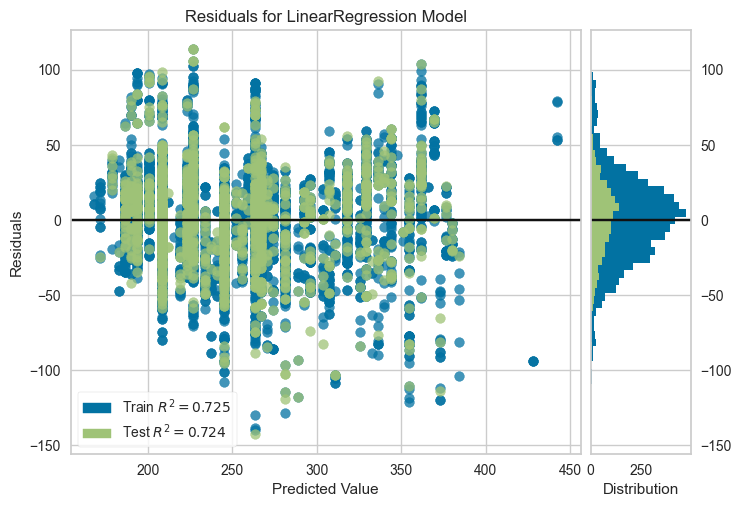

In [82]:
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

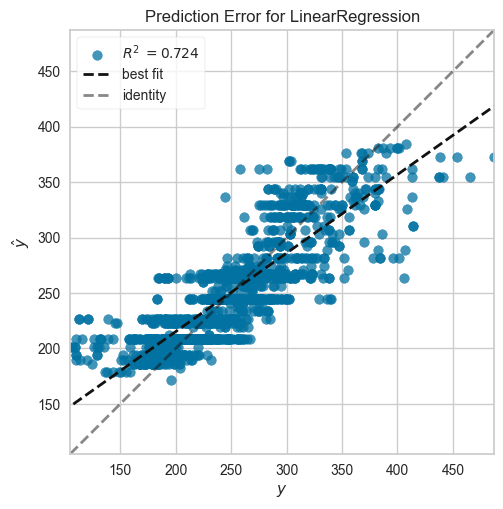

In [83]:
from yellowbrick.regressor import PredictionError

model = LinearRegression()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

# Multiple Lineer Regression

Train-Test Split

In [84]:
df.columns

Index(['make', 'model', 'vehicle_class', 'engine_size', 'cylinders',
       'transmission', 'fuel_type', 'fuel_cons_city', 'fuel_cons_hwy',
       'fuel_cons_comb', 'mpgfuel_cons_comb', 'co2'],
      dtype='object')

In [85]:
X = df[["engine_size", "cylinders", "fuel_cons_comb", "mpgfuel_cons_comb"]]
y = df["co2"]

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [87]:
print("X Train features shape: {}\ny Train features shape: {}\nX Test features shape: {}\ny Test features shape: {}" 
      .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X Train features shape: (5908, 4)
y Train features shape: (5908,)
X Test features shape: (1477, 4)
y Test features shape: (1477,)


 Multiple Lineer Regresyon

In [88]:
multi_lin_reg = LinearRegression()

In [89]:
multi_lin_reg.fit(X_train,y_train)

LinearRegression()

In [90]:
y_pred = multi_lin_reg.predict(X_test)
y_train_pred = multi_lin_reg.predict(X_train)

In [91]:
def train_val(y_train, y_train_pred, y_test, y_pred, i):
    
    scores = {i+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    i+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [92]:
multiple_linear = train_val(y_train, y_train_pred, y_test, y_pred, "multi")
multiple_linear

,multi_train,multi_test
R2,0.903380,0.900396
mae,11.427166,11.676076
mse,330.301688,342.600757
rmse,18.174204,18.509478



Görüldüğü üzere sadece 4 özellik ile yüksek R2 skorları elde edilmiştir. (kategorik özellikler hariç)

# Cross Validation

In [93]:
model = LinearRegression()
scores = cross_validate(model, X_train, y_train,
                        scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error',
                                                            'neg_root_mean_squared_error'], cv = 10)

In [94]:
pd.DataFrame(scores, index = range(1, 11))

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,0.002999,0.002002,0.901253,-11.450945,-338.885163,-18.408834
2,0.003002,0.002000,0.906125,-10.771034,-282.138335,-16.796974
3,0.003001,0.002000,0.905516,-11.687907,-347.007425,-18.628135
4,0.002999,0.002001,0.897220,-11.223875,-314.019278,-17.720589
5,0.004003,0.002999,0.901426,-11.740706,-344.508635,-18.560944
6,0.002999,0.001999,0.883596,-12.016296,-377.492440,-19.429165
7,0.002002,0.002000,0.917169,-10.846386,-298.239263,-17.269605
8,0.002002,0.001999,0.907901,-11.270642,-324.186084,-18.005168
9,0.004001,0.004003,0.905299,-11.173030,-306.171520,-17.497758
10,0.003995,0.003001,0.902219,-12.174987,-380.017899,-19.494048


In [95]:
scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                               0.902772
test_neg_mean_absolute_error        -11.435581
test_neg_mean_squared_error        -331.266604
test_neg_root_mean_squared_error    -18.181122
dtype: float64

Çapraz Doğrulama ve Eğitim-test puanı sonrasında elde edilen bu puanın uyumlu olması modelin genelleme yeteneğine sahip olduğunu göstermektedir.

# Polynomial Features (degree = 5)

In [96]:
def poly(d):
    
    train_rmse_errors = []
    test_rmse_errors = []
    number_of_features = []
    
    for i in range(1, d):
        polynomial_converter = PolynomialFeatures(degree = i, include_bias =False) ## For döngüsü döndükçe degreemiz artıyor,
        poly_features = polynomial_converter.fit_transform(X)                        # bundan dolayı feature sayımız artıyor.
        
        X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)
        
        model = LinearRegression(fit_intercept=True)
        model.fit(X_train, y_train)
        
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        train_RMSE = np.sqrt(mean_squared_error(y_train,train_pred))
        test_RMSE = np.sqrt(mean_squared_error(y_test,test_pred))
        
        train_rmse_errors.append(train_RMSE)
        test_rmse_errors.append(test_RMSE)
        
        number_of_features.append(poly_features.shape[1])
        
    return pd.DataFrame({"train_rmse_errors": train_rmse_errors, "test_rmse_errors":test_rmse_errors, 
                         "number of features":number_of_features}, index=range(1,d))

In [115]:
poly(8)

,train_rmse_errors,test_rmse_errors,number of features
1,18.314047,18.087420,4
2,15.788285,15.680230,14
3,14.314294,13.914205,34
4,12.916365,12.699119,69
5,12.093931,12.490389,125
6,11.139032,13.456477,209
7,19.939590,116.935916,329
8,12.676784,396.862051,494
9,11.968502,1001.277319,714


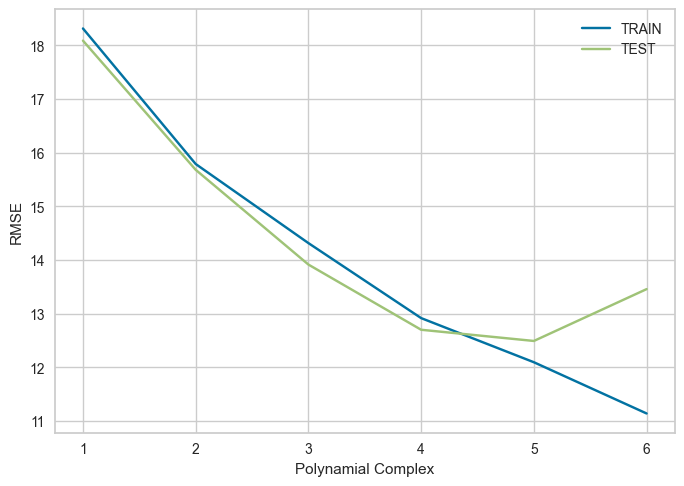

In [117]:
plt.plot(range(1,7), poly(7)["train_rmse_errors"], label = "TRAIN")
plt.plot(range(1,7), poly(7)["test_rmse_errors"], label = "TEST")
plt.xlabel("Polynamial Complex")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [99]:
# degree 5 seçtik
poly_converter = PolynomialFeatures(degree = 5, include_bias=False)

In [100]:
poly_lin_reg = LinearRegression()

In [101]:
X_train, X_test, y_train, y_test = train_test_split(poly_converter.fit_transform(X), y,
                                                    test_size = 0.2, random_state = 42)

In [102]:
poly_lin_reg.fit(X_train, y_train)

LinearRegression()

In [103]:
y_train_pred = poly_lin_reg.predict(X_train)
y_pred = poly_lin_reg.predict(X_test)

In [104]:
poly_multiple_linear = train_val(y_train, y_train_pred, y_test, y_pred, "poly(5)")
poly_multiple_linear

,poly(5)_train,poly(5)_test
R2,0.959309,0.950288
mae,5.721990,6.246782
mse,139.103546,170.989164
rmse,11.794217,13.076282


In [105]:
result = pd.concat([multiple_linear, poly_multiple_linear], axis=1)
result

,multi_train,multi_test,poly(5)_train,poly(5)_test
R2,0.903380,0.900396,0.959309,0.950288
mae,11.427166,11.676076,5.721990,6.246782
mse,330.301688,342.600757,139.103546,170.989164
rmse,18.174204,18.509478,11.794217,13.076282


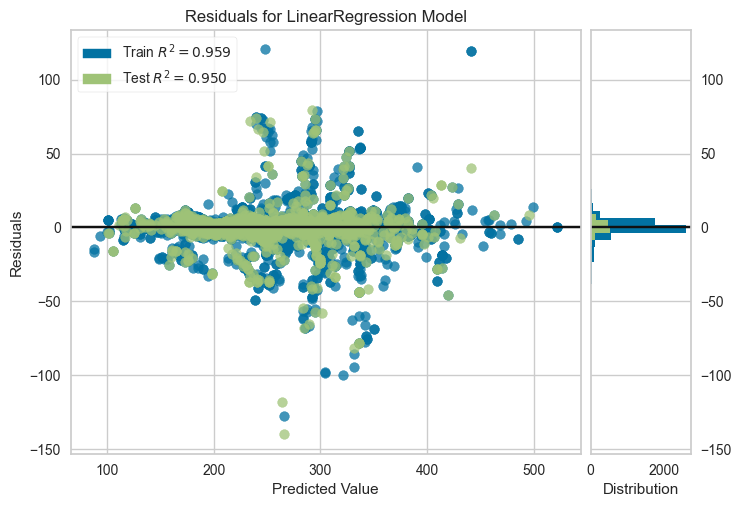

In [106]:
poly_lin_reg = LinearRegression()
visualizer = ResidualsPlot(poly_lin_reg)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

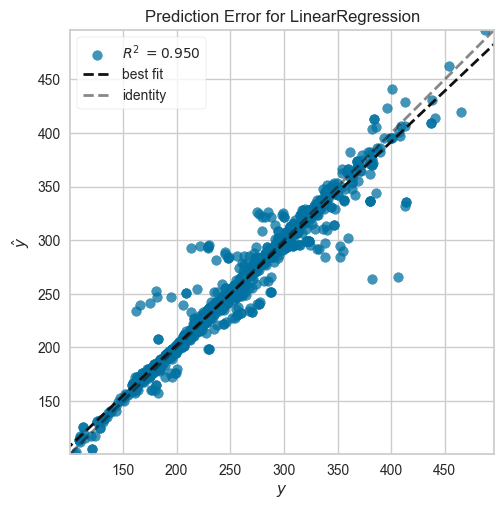

In [61]:
poly_lin_reg = LinearRegression()
visualizer = PredictionError(poly_lin_reg)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

Polynomial Features (degree = 6)

In [107]:
poly_converter2 = PolynomialFeatures(degree = 6, include_bias=False)

In [108]:
poly_lin_reg2 = LinearRegression()

In [109]:
X_train, X_test, y_train, y_test = train_test_split(poly_converter2.fit_transform(X), y,
                                                    test_size = 0.2, random_state = 42)

In [110]:
poly_lin_reg2.fit(X_train, y_train)

LinearRegression()

In [111]:
y_train_pred = poly_lin_reg2.predict(X_train)
y_pred = poly_lin_reg2.predict(X_test)

In [112]:
poly_multiple_linear6 = train_val(y_train, y_train_pred, y_test, y_pred, "poly(6)")
poly_multiple_linear6

,poly(6)_train,poly(6)_test
R2,0.965875,0.818862
mae,5.358223,6.892867
mse,116.656994,623.047602
rmse,10.800787,24.960921


In [113]:
result = pd.concat([result, poly_multiple_linear6], axis=1)
result

,multi_train,multi_test,poly(5)_train,poly(5)_test,poly(6)_train,poly(6)_test
R2,0.903380,0.900396,0.959309,0.950288,0.965875,0.818862
mae,11.427166,11.676076,5.721990,6.246782,5.358223,6.892867
mse,330.301688,342.600757,139.103546,170.989164,116.656994,623.047602
rmse,18.174204,18.509478,11.794217,13.076282,10.800787,24.960921


lasso ridge ve elastic net modellerini kullanabilmemiz için derece 6 ile overfitting oluşturduk. Bu modelleri kullanmadan önce standartlaştırmamız gerekiyor

StandardScaler

In [69]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = StandardScaler()

In [70]:
X_train.shape

(5908, 209)

In [71]:
scaler.fit(X_train)

StandardScaler()

In [72]:
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[-0.12149345,  0.20534188, -0.37681659, ...,  0.14217637,
        -0.0991014 , -0.1352883 ],
       [ 0.6141664 ,  0.20534188,  0.59257065, ..., -0.72488358,
        -0.45513823, -0.23456056],
       [-0.12149345,  0.20534188,  0.24636092, ..., -0.51501106,
        -0.38343999, -0.21853428],
       ...,
       [ 0.24633648,  0.20534188, -0.20371173, ..., -0.18333964,
        -0.23838043, -0.17805417],
       [-0.48932338, -0.88513888, -0.82688924, ...,  0.64777588,
         0.24631392,  0.00835783],
       [ 0.6141664 ,  1.29582264,  0.31560287, ..., -0.47195747,
        -0.37931965, -0.21853428]])

In [73]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled 

array([[-0.12149345,  0.20534188, -0.03060686, ..., -0.27096924,
        -0.28940628, -0.19424162],
       [ 0.90843035,  1.29582264,  1.2849901 , ..., -0.98942374,
        -0.53030578, -0.24823844],
       [ 2.23261809,  1.29582264,  1.04264329, ..., -0.90147536,
        -0.50856895, -0.24474255],
       ...,
       [-1.29854922, -0.88513888, -1.10385702, ...,  1.0457956 ,
         0.59578558,  0.19090711],
       [ 0.24633648,  0.20534188, -0.27295367, ..., -0.00551064,
        -0.17029007, -0.15857477],
       [-0.85715331, -0.88513888, -0.96537313, ...,  0.70673508,
         0.3394726 ,  0.06059508]])

# Ridge Regression

In [74]:
from sklearn.linear_model import Ridge

In [75]:
ridge_model = Ridge(alpha=1, random_state=42)

In [76]:
ridge_model.fit(X_train_scaled, y_train) 

Ridge(alpha=1, random_state=42)

In [77]:
y_pred = ridge_model.predict(X_test_scaled)        
y_train_pred = ridge_model.predict(X_train_scaled)

In [78]:
ridge = train_val(y_train, y_train_pred, y_test, y_pred, "ridge") 
ridge

,ridge_train,ridge_test
R2,0.941473,0.933323
mae,7.168497,7.869761
mse,200.076109,229.345723
rmse,14.144826,15.144165


In [79]:
ridge_model.coef_

array([ 19.16015139,  11.06747963,   7.50456411, -18.11146055,
        11.53195208,  -9.14549672,   9.60556252,  -1.13817654,
        13.93391641,  13.14313643, -20.75444883, -19.13219729,
        -2.39160782,   3.87493922,   3.70803215,  -9.74583521,
        11.62142566,   2.55364796,  -8.35230262, -11.74239878,
       -17.02529496, -10.90688989,  22.39298142, -10.36736071,
        10.43453388,  16.53674907,  -1.07089008,   0.64225192,
        15.71846913,  -5.75174089, -24.86787439,   7.76606617,
       -16.51020982,  11.50289719,  -4.32801833,  -4.15130397,
        16.17195659,  -3.1439619 ,  -5.36953755,  -9.26134778,
       -10.59292447,   8.59733984,  12.3641765 , -11.43206276,
        -2.43054869, -11.11479548, -10.37615076, -18.39970644,
        -7.57344974, -19.79149874, -21.84699152,  11.03599675,
         3.51130938,   7.23449024,   4.41824034,  12.89760069,
        -1.55743557,  11.52764056,  15.8177602 ,  -5.41849598,
        -1.96544196,  16.31175135, -13.58175266,   6.93

In [80]:
result = pd.concat([result, ridge], axis=1)
result

,multi_train,multi_test,poly(5)_train,poly(5)_test,poly(6)_train,poly(6)_test,ridge_train,ridge_test
R2,0.903380,0.900396,0.959309,0.950288,0.965875,0.818862,0.941473,0.933323
mae,11.427166,11.676076,5.721990,6.246782,5.358223,6.892867,7.168497,7.869761
mse,330.301688,342.600757,139.103546,170.989164,116.656994,623.047602,200.076109,229.345723
rmse,18.174204,18.509478,11.794217,13.076282,10.800787,24.960921,14.144826,15.144165


RidgeCV

In [81]:
#RidgeCV ile en iyi alfa değerini bul
alpha_space = np.linspace(0.01, 1, 100)
ridge_cv_model = RidgeCV(alphas = alpha_space, cv = 10, scoring = "neg_root_mean_squared_error")
ridge_cv_model.fit(X_train, y_train)

RidgeCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
        cv=10, scoring='neg_root_mean_squared_error')

In [82]:
ridge_cv_model.alpha_   # EN İYİ ALPHA DEGERİNİ BULMAK İÇİN

0.03

In [83]:
y_pred = ridge_cv_model.predict(X_test)
y_train_pred = ridge_cv_model.predict(X_train)

In [84]:
ridge_cv = train_val(y_train, y_train_pred, y_test, y_pred, "ridgeCV")
ridge_cv

,ridgeCV_train,ridgeCV_test
R2,0.963127,0.935296
mae,5.446202,6.184577
mse,126.052135,222.558418
rmse,11.227294,14.918392


Önemsiz değişkenlerin katsayıları sıfıra yaklaşıyor

In [85]:
ridge_cv_model.coef_ 

array([ 1.54985906e-01,  1.75980167e-02,  2.53268417e+00, -2.21919719e+00,
       -2.84810418e-01, -8.17314239e-01, -2.05296586e+00,  1.10671032e+01,
       -1.07798489e+00,  3.35830217e+00, -2.53910000e+00,  3.09125108e+01,
        2.82491607e+00, -3.51458833e+01,  7.16192365e+00,  2.12543890e-01,
       -4.01666379e+00,  1.58374468e+01, -4.00731712e+00, -1.30095554e+01,
        8.64856631e+00, -1.29920405e+01, -1.25684298e+01,  1.80886566e+02,
       -5.24345375e+00, -6.53350444e+00,  3.88899707e-01,  3.21368831e+01,
       -7.91636834e+00, -5.75441968e+01,  7.43896801e+01,  1.22679196e+02,
        2.37778555e+01,  3.10611845e+00,  3.40278611e+01,  2.92776778e+01,
        2.85555039e+01,  9.05456632e+01,  3.74821557e+01, -9.18540490e+00,
        1.19876871e+01,  5.67643089e+01, -1.96940673e+01,  1.56396356e+01,
        1.63118503e+01, -2.52534872e+01, -1.94850807e+01, -1.30223986e+02,
        2.83159084e+01, -2.87242536e+01, -3.21546642e-01, -2.08558984e+01,
       -3.61610121e+01, -

In [87]:
result = pd.concat([result, ridge_cv], axis=1)
result

,multi_train,multi_test,poly(5)_train,poly(5)_test,poly(6)_train,poly(6)_test,ridge_train,ridge_test,ridgeCV_train,ridgeCV_test,ridgeCV_train,ridgeCV_test
R2,0.903380,0.900396,0.959309,0.950288,0.965875,0.818862,0.941473,0.933323,0.963127,0.935296,0.963127,0.935296
mae,11.427166,11.676076,5.721990,6.246782,5.358223,6.892867,7.168497,7.869761,5.446202,6.184577,5.446202,6.184577
mse,330.301688,342.600757,139.103546,170.989164,116.656994,623.047602,200.076109,229.345723,126.052135,222.558418,126.052135,222.558418
rmse,18.174204,18.509478,11.794217,13.076282,10.800787,24.960921,14.144826,15.144165,11.227294,14.918392,11.227294,14.918392


# Lasso Regression

In [88]:
lasso_model = Lasso(alpha = 1, random_state = 42)
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=1, random_state=42)

In [89]:
y_pred = lasso_model.predict(X_test_scaled)
y_train_pred = lasso_model.predict(X_train_scaled)

In [90]:
lss = train_val(y_train, y_train_pred, y_test, y_pred, "lasso")
lss

,lasso_train,lasso_test
R2,0.910909,0.905296
mae,11.048065,11.404326
mse,304.561235,325.745246
rmse,17.451683,18.048414


In [91]:
lasso_model.coef_   # Görüldüğü gibi önemi az olan özellikler sıfırdır.

array([  0.        ,   0.        ,   0.        , -34.35301026,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  13.81471249,  -0.        ,   0.        ,
         0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   2.29186039,  -0.        ,
         0.        ,   0.66912106,   0.        ,   0.        ,
         0.        ,  -0.        ,  -0.        ,   0.        ,
        -0.        ,  -0.        ,   0.        ,   0.        ,
         2.49140929,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  -0.        ,
         0.        ,   0.40846133,  -0.        ,  -0.  

In [92]:
nonzero_features = np.count_nonzero(lasso_model.coef_)         #   sıfır olmayan katsayılar
nonzero_features

13

In [93]:
result = pd.concat([result, lss], axis=1)
result

,multi_train,multi_test,poly(5)_train,poly(5)_test,poly(6)_train,poly(6)_test,ridge_train,ridge_test,ridgeCV_train,ridgeCV_test,ridgeCV_train,ridgeCV_test,lasso_train,lasso_test
R2,0.903380,0.900396,0.959309,0.950288,0.965875,0.818862,0.941473,0.933323,0.963127,0.935296,0.963127,0.935296,0.910909,0.905296
mae,11.427166,11.676076,5.721990,6.246782,5.358223,6.892867,7.168497,7.869761,5.446202,6.184577,5.446202,6.184577,11.048065,11.404326
mse,330.301688,342.600757,139.103546,170.989164,116.656994,623.047602,200.076109,229.345723,126.052135,222.558418,126.052135,222.558418,304.561235,325.745246
rmse,18.174204,18.509478,11.794217,13.076282,10.800787,24.960921,14.144826,15.144165,11.227294,14.918392,11.227294,14.918392,17.451683,18.048414


LassoCV

In [94]:
#Lasso CV ile en iyi alfa değerini bulun
lasso_cv_model = LassoCV(alphas = alpha_space, cv = 10, max_iter=1000000, random_state=42)
lasso_cv_model.fit(X_train_scaled, y_train)

LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
        cv=10, max_iter=1000000, random_state=42)

In [95]:
lasso_cv_model.alpha_  

0.01

In [96]:
y_pred = lasso_cv_model.predict(X_test_scaled)           # Lasso(alpha =0.01)
y_train_pred = lasso_cv_model.predict(X_train_scaled)

In [97]:
lasso_cv = train_val(y_train, y_train_pred, y_test, y_pred, "lassoCV")
lasso_cv

,lassoCV_train,lassoCV_test
R2,0.938429,0.929081
mae,7.429202,8.197321
mse,210.484371,243.933921
rmse,14.508080,15.618384


In [98]:
nonzero_features = np.count_nonzero(lasso_cv_model.coef_)         # o olmayan katsayılar (burayı anlatalım)katsayı artınca r2 de arttı. 
nonzero_features

28

In [99]:
result = pd.concat([result, lasso_cv], axis=1)
result

,multi_train,multi_test,poly(5)_train,poly(5)_test,poly(6)_train,poly(6)_test,ridge_train,ridge_test,ridgeCV_train,ridgeCV_test,ridgeCV_train,ridgeCV_test,lasso_train,lasso_test,lassoCV_train,lassoCV_test
R2,0.903380,0.900396,0.959309,0.950288,0.965875,0.818862,0.941473,0.933323,0.963127,0.935296,0.963127,0.935296,0.910909,0.905296,0.938429,0.929081
mae,11.427166,11.676076,5.721990,6.246782,5.358223,6.892867,7.168497,7.869761,5.446202,6.184577,5.446202,6.184577,11.048065,11.404326,7.429202,8.197321
mse,330.301688,342.600757,139.103546,170.989164,116.656994,623.047602,200.076109,229.345723,126.052135,222.558418,126.052135,222.558418,304.561235,325.745246,210.484371,243.933921
rmse,18.174204,18.509478,11.794217,13.076282,10.800787,24.960921,14.144826,15.144165,11.227294,14.918392,11.227294,14.918392,17.451683,18.048414,14.508080,15.618384


ElasticNet Regression

In [100]:
elastic_model = ElasticNet(alpha = 1, l1_ratio = 0.5, random_state = 42)
elastic_model.fit(X_train_scaled, y_train)

ElasticNet(alpha=1, random_state=42)

In [101]:
y_pred = elastic_model.predict(X_test_scaled)
y_train_pred = elastic_model.predict(X_train_scaled)

In [102]:
elastic = train_val(y_train, y_train_pred, y_test, y_pred, "elastic")
elastic

,elastic_train,elastic_test
R2,0.905443,0.900398
mae,12.124323,12.444614
mse,323.249322,342.594176
rmse,17.979136,18.509300


In [103]:
result = pd.concat([result, elastic], axis=1)
result

,multi_train,multi_test,poly(5)_train,poly(5)_test,poly(6)_train,poly(6)_test,ridge_train,ridge_test,ridgeCV_train,ridgeCV_test,ridgeCV_train,ridgeCV_test,lasso_train,lasso_test,lassoCV_train,lassoCV_test,elastic_train,elastic_test
R2,0.903380,0.900396,0.959309,0.950288,0.965875,0.818862,0.941473,0.933323,0.963127,0.935296,0.963127,0.935296,0.910909,0.905296,0.938429,0.929081,0.905443,0.900398
mae,11.427166,11.676076,5.721990,6.246782,5.358223,6.892867,7.168497,7.869761,5.446202,6.184577,5.446202,6.184577,11.048065,11.404326,7.429202,8.197321,12.124323,12.444614
mse,330.301688,342.600757,139.103546,170.989164,116.656994,623.047602,200.076109,229.345723,126.052135,222.558418,126.052135,222.558418,304.561235,325.745246,210.484371,243.933921,323.249322,342.594176
rmse,18.174204,18.509478,11.794217,13.076282,10.800787,24.960921,14.144826,15.144165,11.227294,14.918392,11.227294,14.918392,17.451683,18.048414,14.508080,15.618384,17.979136,18.509300


ElasticNET CV

In [104]:
#Find the best alpha and l1_ratio values

elastic_cv_model = ElasticNetCV(alphas = alpha_space, l1_ratio=[0.1, 0.5, 0.7,0.9, 0.95, 1], cv = 10, 
                                max_iter = 1000000,random_state=42)

In [105]:
elastic_cv_model.fit(X_train_scaled, y_train)

ElasticNetCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
             cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 1], max_iter=1000000,
             random_state=42)

In [106]:
elastic_cv_model.alpha_

0.01

In [107]:
y_pred = elastic_cv_model.predict(X_test_scaled)
y_train_pred = elastic_cv_model.predict(X_train_scaled)

In [108]:
elastic_cv = train_val(y_train, y_train_pred, y_test, y_pred, "elasticCV")
elastic_cv

,elasticCV_train,elasticCV_test
R2,0.938429,0.929081
mae,7.429202,8.197321
mse,210.484371,243.933921
rmse,14.508080,15.618384


In [109]:
nonzero_features = np.count_nonzero(elastic_cv_model.coef_)         # 0 olan katsayılar  
nonzero_features  

28

In [110]:
result = pd.concat([result, elastic_cv], axis=1)   
result

,multi_train,multi_test,poly(5)_train,poly(5)_test,poly(6)_train,poly(6)_test,ridge_train,ridge_test,ridgeCV_train,ridgeCV_test,ridgeCV_train,ridgeCV_test,lasso_train,lasso_test,lassoCV_train,lassoCV_test,elastic_train,elastic_test,elasticCV_train,elasticCV_test
R2,0.903380,0.900396,0.959309,0.950288,0.965875,0.818862,0.941473,0.933323,0.963127,0.935296,0.963127,0.935296,0.910909,0.905296,0.938429,0.929081,0.905443,0.900398,0.938429,0.929081
mae,11.427166,11.676076,5.721990,6.246782,5.358223,6.892867,7.168497,7.869761,5.446202,6.184577,5.446202,6.184577,11.048065,11.404326,7.429202,8.197321,12.124323,12.444614,7.429202,8.197321
mse,330.301688,342.600757,139.103546,170.989164,116.656994,623.047602,200.076109,229.345723,126.052135,222.558418,126.052135,222.558418,304.561235,325.745246,210.484371,243.933921,323.249322,342.594176,210.484371,243.933921
rmse,18.174204,18.509478,11.794217,13.076282,10.800787,24.960921,14.144826,15.144165,11.227294,14.918392,11.227294,14.918392,17.451683,18.048414,14.508080,15.618384,17.979136,18.509300,14.508080,15.618384


In [111]:
result.T  # lassoCV ve elasticCV aynı R2 puanlarına sahiptir (çünkü elasticCV l1_ratio parametresi 1'dir)

,R2,mae,mse,rmse
multi_train,0.903380,11.427166,330.301688,18.174204
multi_test,0.900396,11.676076,342.600757,18.509478
poly(5)_train,0.959309,5.721990,139.103546,11.794217
poly(5)_test,0.950288,6.246782,170.989164,13.076282
poly(6)_train,0.965875,5.358223,116.656994,10.800787
poly(6)_test,0.818862,6.892867,623.047602,24.960921
ridge_train,0.941473,7.168497,200.076109,14.144826
ridge_test,0.933323,7.869761,229.345723,15.144165
ridgeCV_train,0.963127,5.446202,126.052135,11.227294
ridgeCV_test,0.935296,6.184577,222.558418,14.918392


Grid Search

l1 = LASSO

l2 = RIDGE

l1 = 05 = lasso + ridge

ElasticCV ile yaptığımızın aynısını GridSearch ile de yapalım

In [112]:
elastic_model = ElasticNet(max_iter=100000, random_state=42)

In [113]:
param_grid = {"alpha":[0.01, 0.012, 0.2, 0.5, 0.6, 0.7, 1],
            "l1_ratio":[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]}

In [114]:
grid_model = GridSearchCV(estimator = elastic_model, #alpha: Regularizasyon katsayısıdır. Daha yüksek alpha değerleri daha fazla düzenlileştirme (penalizasyon) sağlar.
                                                      #l1_ratio: ElasticNet'in L1 ve L2 cezaları arasındaki oranı belirler. Değerler arasında geçiş yaparak L1 ve L2 cezalarının etkilerini değiştirebilir.
                          param_grid = param_grid, 
                          scoring = 'neg_root_mean_squared_error',
                          cv =5, verbose =2)

In [ ]:
grid_model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time= 1.4min
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time= 1.4min
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time= 1.5min
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time= 1.4min
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time= 1.6min
[CV] END ...........................alpha=0.01, l1_ratio=0.5; total time= 1.4min
[CV] END ...........................alpha=0.01, l1_ratio=0.5; total time= 1.4min
[CV] END ...........................alpha=0.01, l1_ratio=0.5; total time= 1.4min
[CV] END ...........................alpha=0.01, l1_ratio=0.5; total time= 1.4min


burda durdurdum çünkü çok zaman aldı ve fanlar kulagımı tırmaladı

In [ ]:
grid_model.best_params_ 

In [ ]:
grid_model.best_index_ 

In [ ]:
grid_model.best_score_

# Using Best Hyper Parameters From GridSearch

In [118]:
y_pred = grid_model.predict(X_test_scaled)          # ElasticNet(alpha= 0.01, l1_ratio= 1)
y_train_pred = grid_model.predict(X_train_scaled)

NameError: name 'grid_model' is not defined

In [ ]:
gridsearch = train_val(y_train, y_train_pred, y_test, y_pred, "GridSearch")
gridsearch

In [ ]:
result = pd.concat([result, gridsearch], axis=1)   
result

# Final Model

In [118]:
final_scaler = StandardScaler()
X_scaled = final_scaler.fit_transform(poly_converter2.fit_transform(X))

In [119]:
final_model = Lasso(alpha=0.01)      # Lasso model built over 28 features with our best alpha value

In [120]:
final_model.fit(X_scaled, y)

Lasso(alpha=0.01)

Continuing with polynomial features degree 6, the best score (test = 0.9290) is LassoCV with 28 features (alpha= 0.01)

continuing with polynomial features degree 5, the best score (test = 0.9502) is Multiple Linear Regression with 125 features.

# Feature importances with Ridge

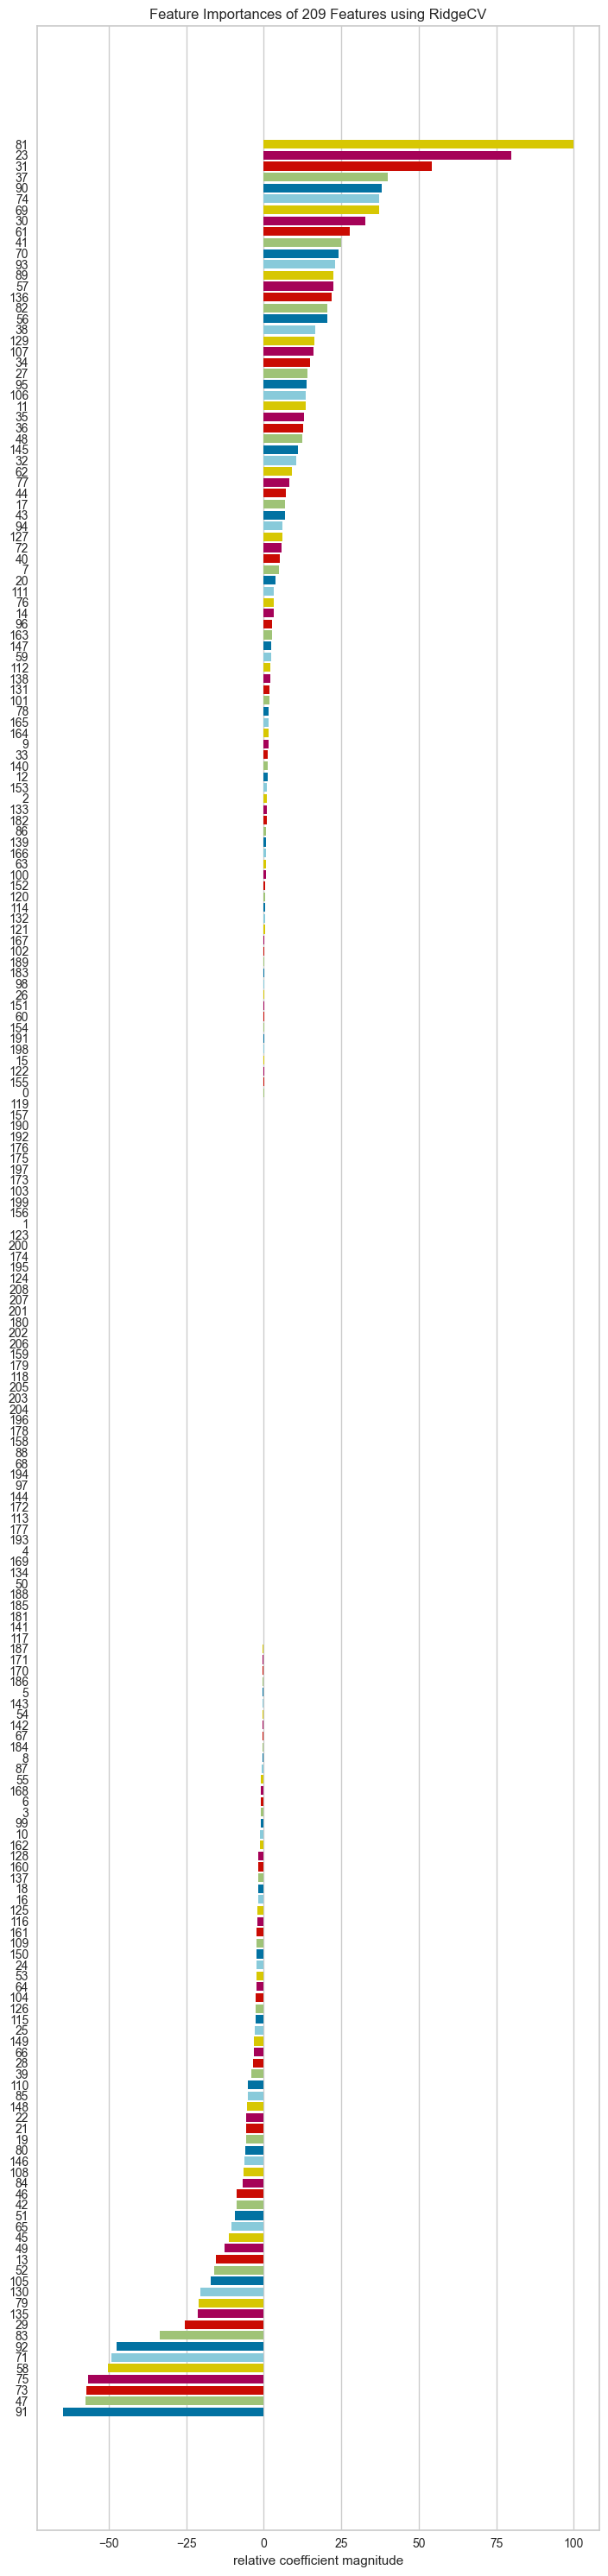

<AxesSubplot:title={'center':'Feature Importances of 209 Features using RidgeCV'}, xlabel='relative coefficient magnitude'>

In [121]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz  ## figsize gibi işlem yapıyor

viz = FeatureImportances(ridge_cv_model, labels=pd.DataFrame(X_train_scaled).columns)
visualizer = RadViz(size=(720, 3000))
viz.fit(X_train_scaled, y_train)
viz.show()

# Feature importances with Lasso

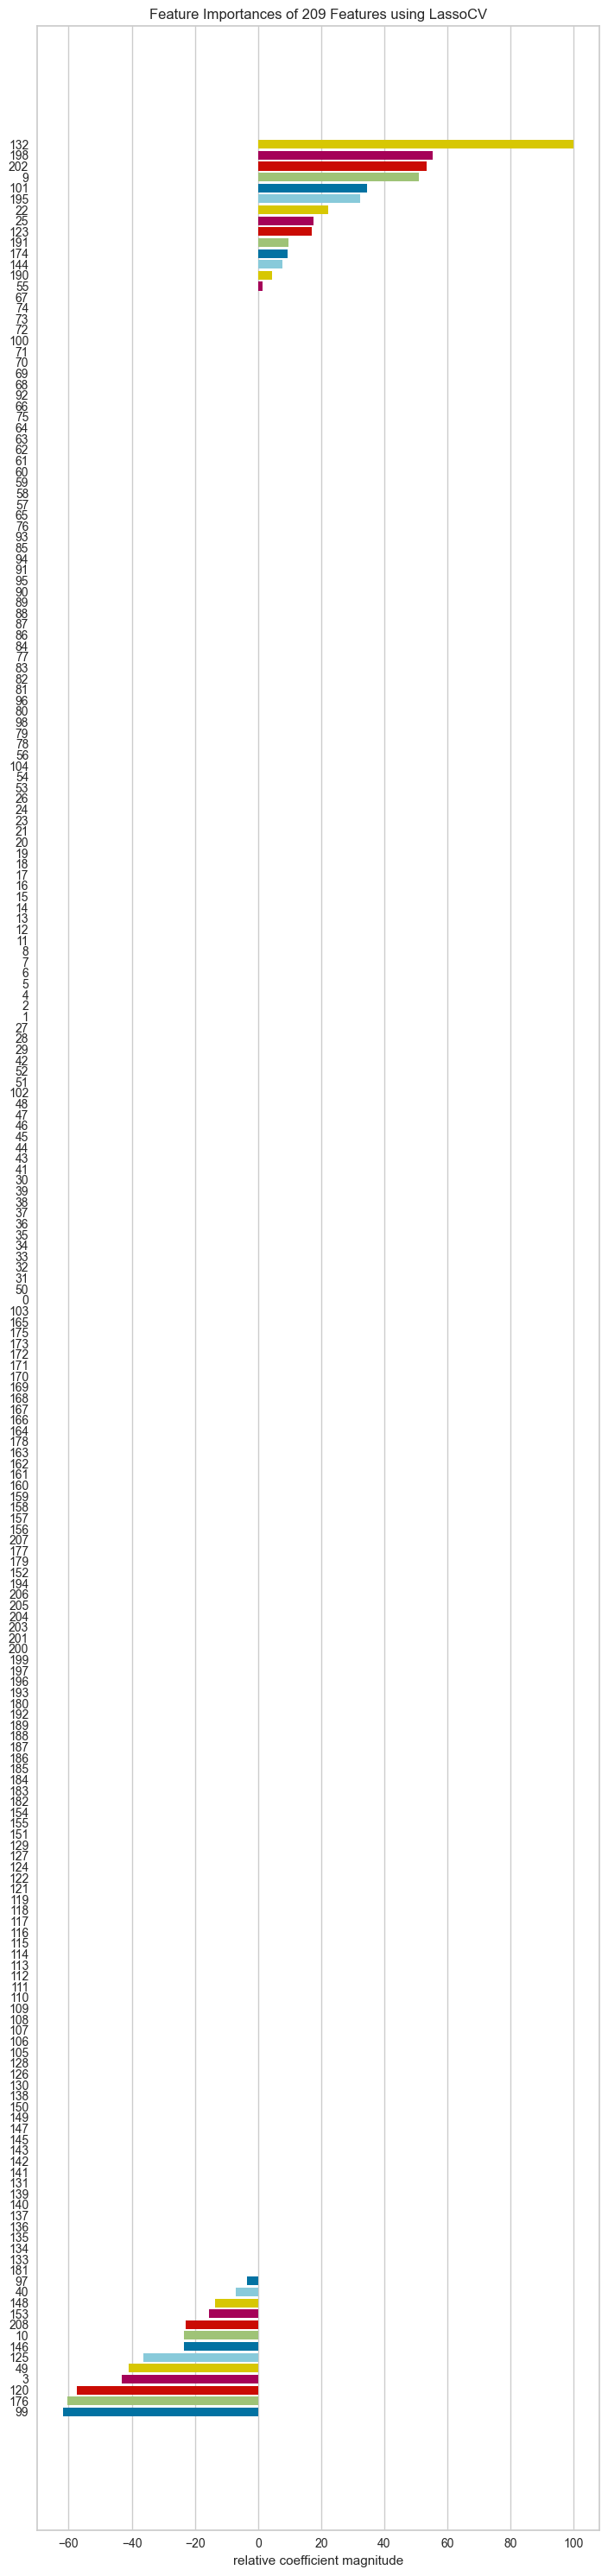

<AxesSubplot:title={'center':'Feature Importances of 209 Features using LassoCV'}, xlabel='relative coefficient magnitude'>

In [122]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

viz = FeatureImportances(lasso_cv_model, labels=pd.DataFrame(X_train_scaled).columns)
visualizer = RadViz(size=(720, 3000))
viz.fit(X_train_scaled, y_train)
viz.show()

I would like to thank my valuable teachers who made these for us like embroidery.